In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm as tqdm
import random
import os
import json
import numpy as np

import george
from functools import partial
import scipy.optimize as op
from astropy.table import Table, vstack
from gaussian_process_example import *

df = pd.read_csv('gp_objects.csv')
display(df)
obj = sorted(df.obj_id.unique())

mjd   flux_ztfg   flux_ztfi   flux_ztfr  flux_error_ztfg  \
0      57983.231000  385.374906  440.341788  404.940209        29.250027   
1      57983.239778  382.559484  438.232033  402.502588        28.789575   
2      57983.248556  379.738177  436.119876  400.065220        28.332873   
3      57983.257333  376.910979  434.005567  397.628148        27.879986   
4      57983.266111  374.077886  431.889351  395.191413        27.430981   
...             ...         ...         ...         ...              ...   
72996  60652.513689   33.493383         NaN   40.961798         3.488673   
72997  60652.519801   33.463261         NaN   40.930338         3.842217   
72998  60652.525913   33.432509         NaN   40.895906         4.235472   
72999  60652.532025   33.401076         NaN   40.858402         4.657035   
73000  60652.538137   33.368917         NaN   40.817727         5.098662   

       flux_error_ztfi  flux_error_ztfr      type        obj_id         mjd_0  \
0            17.182907        24.797305  Kilonova     AT2017gfo  57983.231000   
1            16.890215        24.361032  Kilonova     AT2017gfo  57983.231000   
2            16.606597        23.927709  Kilonova     AT2017gfo  57983.231000   
3            16.332054        23.497397  Kilonova     AT2017gfo  57983.231000   
4            16.066587        23.070161  Kilonova     AT2017gfo  57983.231000   
...                ...              ...       ...           ...           ...   
72996              NaN         5.252959       IIb  ZTF24abvevzs  60646.432303   
72997              NaN         5.054402       IIb  ZTF24abvevzs  60646.432303   
72998              NaN         4.909244       IIb  ZTF24abvevzs  60646.432303   
72999              NaN         4.823773       IIb  ZTF24abvevzs  60646.432303   
73000              NaN         4.802653       IIb  ZTF24abvevzs  60646.432303   

       ...   mag_ztfg  abs_mag_ztfg  mag_error_ztfg   mag_ztfr  abs_mag_ztfr  \
0      ...  17.435291    -15.778388        0.082408  17.381523    -15.832157   
1      ...  17.443253    -15.770427        0.081707  17.388078    -15.825601   
2      ...  17.451289    -15.762390        0.081009  17.394673    -15.819007   
3      ...  17.459403    -15.754277        0.080312  17.401307    -15.812372   
4      ...  17.467595    -15.746085        0.079617  17.407981    -15.805698   
...    ...        ...           ...             ...        ...           ...   
72996  ...  20.087602    -15.921953        0.113090  19.869052    -16.140503   
72997  ...  20.088579    -15.920976        0.124663  19.869887    -16.139669   
72998  ...  20.089578    -15.919978        0.137549  19.870800    -16.138755   
72999  ...  20.090599    -15.918957        0.151382  19.871797    -16.137759   
73000  ...  20.091645    -15.917911        0.165897  19.872878    -16.136678   

       mag_error_ztfr   mag_ztfi  abs_mag_ztfi  mag_error_ztfi         t  
0            0.066487  17.290525    -15.923154        0.042367  0.000000  
1            0.065713  17.295740    -15.917940        0.041846  0.008778  
2            0.064937  17.300985    -15.912694        0.041343  0.017556  
3            0.064160  17.306262    -15.907418        0.040857  0.026333  
4            0.063382  17.311569    -15.902111        0.040390  0.035111  
...               ...        ...           ...             ...       ...  
72996        0.139235        NaN           NaN             NaN  6.081386  
72997        0.134075        NaN           NaN             NaN  6.087498  
72998        0.130334        NaN           NaN             NaN  6.093610  
72999        0.128183        NaN           NaN             NaN  6.099721  
73000        0.127749        NaN           NaN             NaN  6.105833  

[73001 rows x 21 columns]

In [2]:
color_dict = {'ztfg': 'green', 'ztfr': 'red', 'ztfi': 'yellow'}
def plot_gp(obj_model, number_col=4, show_title=True, show_legend=True):
    color_dict = {'ztfg': 'green', 'ztfr': 'red', 'ztfi': 'yellow'}
    f, ax = plt.subplots(figsize=(10, 6))
    ax.set_xlabel('Time (mjd)')
    ax.set_ylabel('Flux') 
    if show_title:
        obj_id = obj_model['obj_id'].iloc[0]
        ax.set_title(f'Light Curve for Object ID: {obj_id} | Type: {obj_model["type"].iloc[0]}')
    if show_legend:
        ax.legend(ncol=number_col)

    # Plotting model data if available
    if obj_model is not None:
        # Iterate over the filters present in the obj_model DataFrame
        for column in obj_model.columns:
            if 'flux' in column and column != 'mjd' and 'abs' not in column:
                filter_name = column.split('_')[1]
                if filter_name in color_dict:
                    if not all(obj_model[column] == -1):
                        ax.plot(obj_model['t'], obj_model[column], label=f'Model {filter_name}', color=color_dict[filter_name])
    
                        # Plot error band if error data is available
                        error_column = f'flux_error_{filter_name}'
                        if error_column in obj_model.columns:
                            model_flux_error = obj_model[error_column]
                            ax.fill_between(obj_model['t'], obj_model[column]-model_flux_error, obj_model[column]+model_flux_error, color=color_dict[filter_name], alpha=0.20)

    return f,ax

In [3]:
def cut_data(df, obj_id, cutoff, plot=True):
    obj_model = df[df['obj_id'] == obj_id]
    if plot:
        f, ax = plot_gp(obj_model)
        ax.axvline(cutoff, color='black', linestyle='--', label='Cutoff')
        plt.show()

    obj_model = obj_model[obj_model['t'] < cutoff]
    combined_df = pd.concat([df[df['obj_id'] != obj_id], obj_model])
    return combined_df

In [4]:
obj[1+51]

'ZTF22abmsaxp'

In [5]:
df[df['obj_id'] == obj[30]]

mjd  flux_ztfg  flux_ztfi   flux_ztfr  flux_error_ztfg  \
30000  59178.482199  81.719682        NaN   71.921369         4.371039   
30001  59178.532211  81.349487        NaN   71.504558         4.367359   
30002  59178.582224  80.978890        NaN   71.086910         4.404943   
30003  59178.632236  80.608064        NaN   70.668733         4.480966   
30004  59178.682249  80.237185        NaN   70.250375         4.591794   
...             ...        ...        ...         ...              ...   
30995  59228.244522  47.994131        NaN  137.360337         2.163514   
30996  59228.294535  47.591542        NaN  137.215163         2.188344   
30997  59228.344547  47.191105        NaN  137.065566         2.237903   
30998  59228.394559  46.794370        NaN  136.911393         2.314851   
30999  59228.444572  46.402276        NaN  136.752819         2.419597   

       flux_error_ztfi  flux_error_ztfr type        obj_id         mjd_0  ...  \
30000              NaN         5.287658  IIb  ZTF20actqnhg  59178.482199  ...   
30001              NaN         5.216915  IIb  ZTF20actqnhg  59178.482199  ...   
30002              NaN         5.171833  IIb  ZTF20actqnhg  59178.482199  ...   
30003              NaN         5.151400  IIb  ZTF20actqnhg  59178.482199  ...   
30004              NaN         5.154126  IIb  ZTF20actqnhg  59178.482199  ...   
...                ...              ...  ...           ...           ...  ...   
30995              NaN         2.647859  IIb  ZTF20actqnhg  59178.482199  ...   
30996              NaN         2.717161  IIb  ZTF20actqnhg  59178.482199  ...   
30997              NaN         2.804400  IIb  ZTF20actqnhg  59178.482199  ...   
30998              NaN         2.910944  IIb  ZTF20actqnhg  59178.482199  ...   
30999              NaN         3.036920  IIb  ZTF20actqnhg  59178.482199  ...   

        mag_ztfg  abs_mag_ztfg  mag_error_ztfg   mag_ztfr  abs_mag_ztfr  \
30000  19.119183    -16.620500        0.058074  19.257855    -16.481828   
30001  19.124113    -16.615571        0.058289  19.264166    -16.475518   
30002  19.129070    -16.610613        0.059060  19.270526    -16.469158   
30003  19.134054    -16.605630        0.060356  19.276932    -16.462752   
30004  19.139061    -16.600623        0.062134  19.283378    -16.456305   
...          ...           ...             ...        ...           ...   
30995  19.697030    -16.042654        0.048944  18.555347    -17.184337   
30996  19.706176    -16.033508        0.049924  18.556495    -17.183189   
30997  19.715350    -16.024334        0.051488  18.557679    -17.182005   
30998  19.724516    -16.015168        0.053710  18.558901    -17.180783   
30999  19.733652    -16.006032        0.056615  18.560159    -17.179524   

       mag_error_ztfr  mag_ztfi  abs_mag_ztfi  mag_error_ztfi          t  
30000        0.079823       NaN           NaN             NaN   0.000000  
30001        0.079214       NaN           NaN             NaN   0.050012  
30002        0.078991       NaN           NaN             NaN   0.100025  
30003        0.079145       NaN           NaN             NaN   0.150037  
30004        0.079658       NaN           NaN             NaN   0.200050  
...               ...       ...           ...             ...        ...  
30995        0.020929       NaN           NaN             NaN  49.762323  
30996        0.021500       NaN           NaN             NaN  49.812336  
30997        0.022214       NaN           NaN             NaN  49.862348  
30998        0.023084       NaN           NaN             NaN  49.912360  
30999        0.024111       NaN           NaN             NaN  49.962373  

[1000 rows x 21 columns]

In [6]:
df[df['obj_id'] == obj[7]].describe()

mjd    flux_ztfg  flux_ztfi    flux_ztfr  flux_error_ztfg  \
count   1000.000000  1000.000000        0.0  1000.000000      1000.000000   
mean   58597.816117   183.240171        NaN   159.572482        16.340975   
std        8.359731   118.369048        NaN   109.834246         4.714176   
min    58583.358345    37.237861        NaN    25.213199         4.146844   
25%    58590.587231    69.404153        NaN    51.971791        12.950148   
50%    58597.816117   155.415815        NaN   131.196179        16.746612   
75%    58605.045003   300.261026        NaN   276.223232        20.435642   
max    58612.273889   378.976388        NaN   327.480817        23.302721   

       flux_error_ztfi  flux_error_ztfr         mjd_0    redshift  \
count              0.0      1000.000000  1.000000e+03  1000.00000   
mean               NaN        19.957125  5.858336e+04     0.05469   
std                NaN         7.372145  7.279598e-12     0.00000   
min                NaN         4.663951  5.858336e+04     0.05469   
25%                NaN        13.819034  5.858336e+04     0.05469   
50%                NaN        19.954346  5.858336e+04     0.05469   
75%                NaN        23.725766  5.858336e+04     0.05469   
max                NaN        34.083335  5.858336e+04     0.05469   

          mag_ztfg  abs_mag_ztfg  mag_error_ztfg     mag_ztfr  abs_mag_ztfr  \
count  1000.000000   1000.000000     1000.000000  1000.000000   1000.000000   
mean     18.527526    -18.481901        0.164905    18.743734    -18.265694   
std       0.840248      0.840248        0.148486     0.951484      0.951484   
min      17.453470    -19.555958        0.046161    17.612035    -19.397392   
25%      17.706253    -19.303175        0.067068    17.796850    -19.212578   
50%      18.421263    -18.588164        0.089243    18.605198    -18.404229   
75%      19.296538    -17.712889        0.237520    19.610583    -17.398844   
max      19.972538    -17.036889        0.577762    20.395930    -16.613497   

       mag_error_ztfr  mag_ztfi  abs_mag_ztfi  mag_error_ztfi            t  
count     1000.000000       0.0           0.0             0.0  1000.000000  
mean         0.261023       NaN           NaN             NaN    14.457772  
std          0.232465       NaN           NaN             NaN     8.359731  
min          0.043288       NaN           NaN             NaN     0.000000  
25%          0.074516       NaN           NaN             NaN     7.228886  
50%          0.147170       NaN           NaN             NaN    14.457772  
75%          0.417071       NaN           NaN             NaN    21.686658  
max          0.857379       NaN           NaN             NaN    28.915544

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


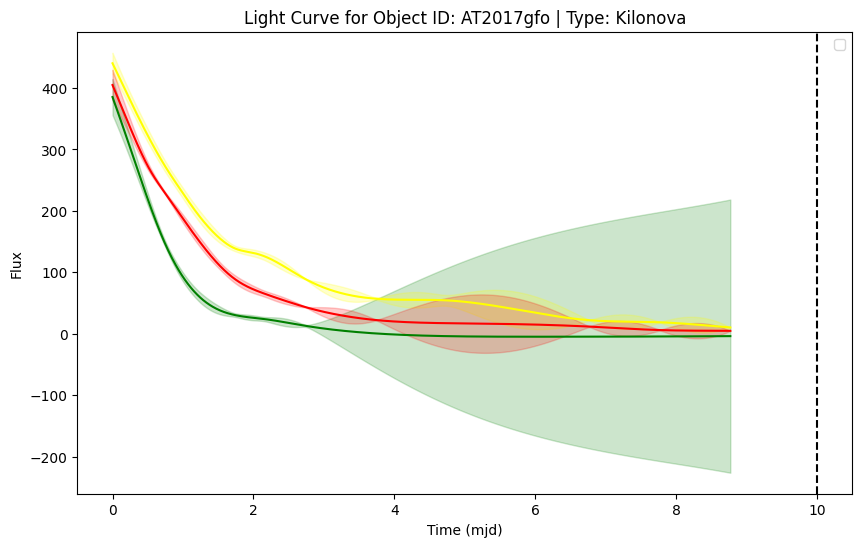

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


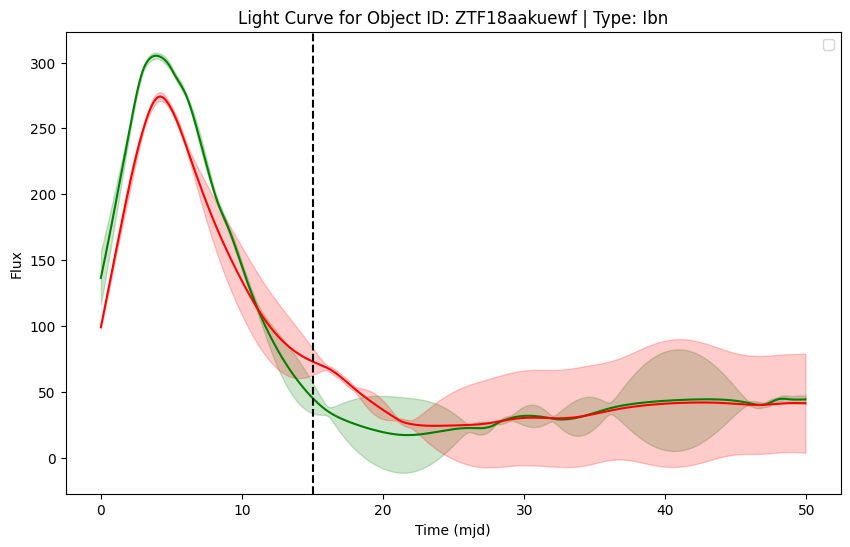

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


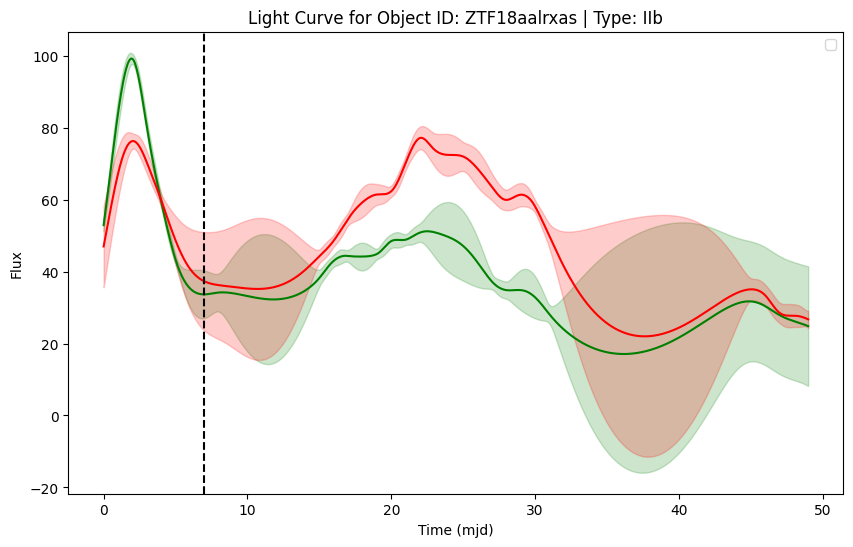

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


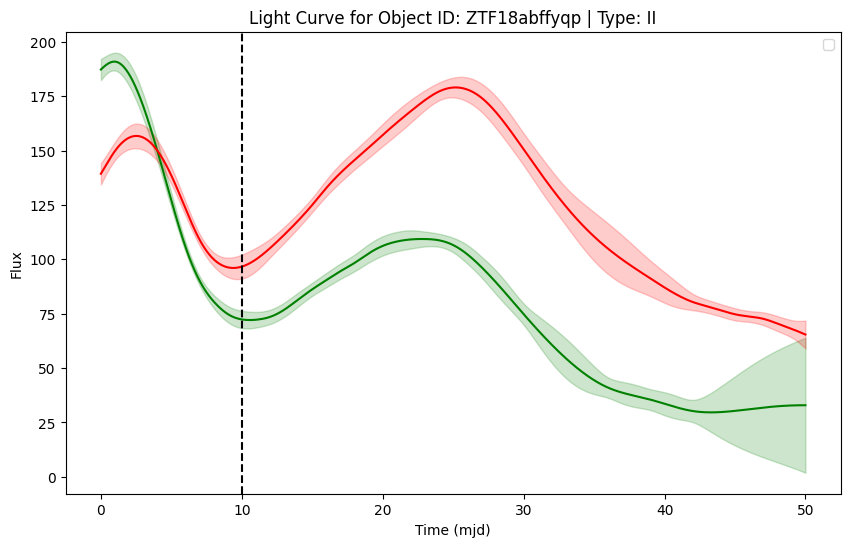

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


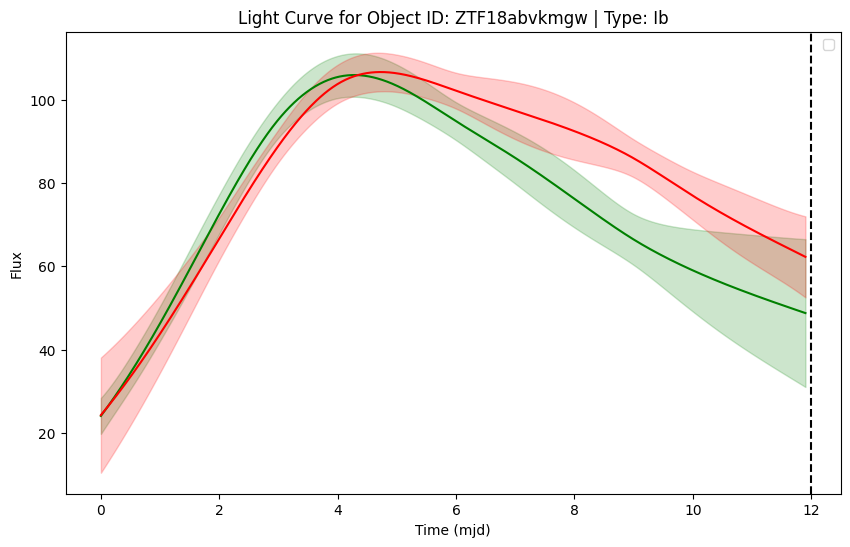

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


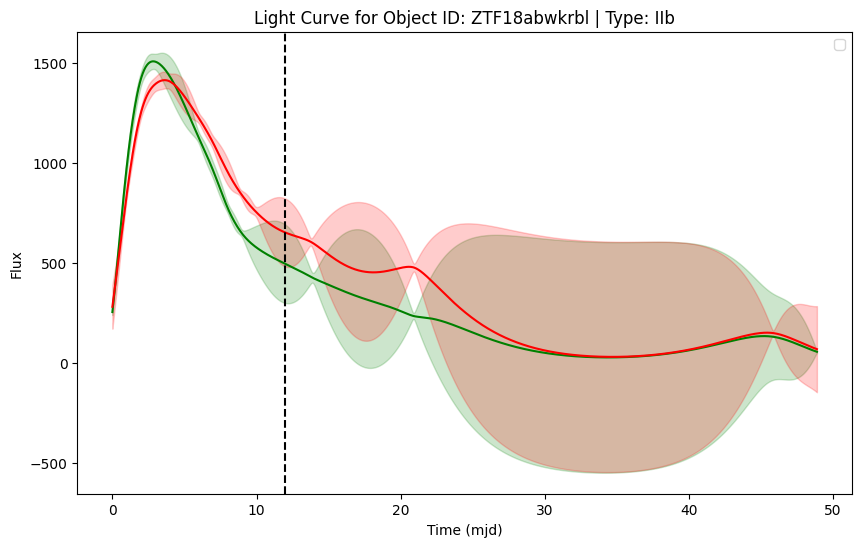

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


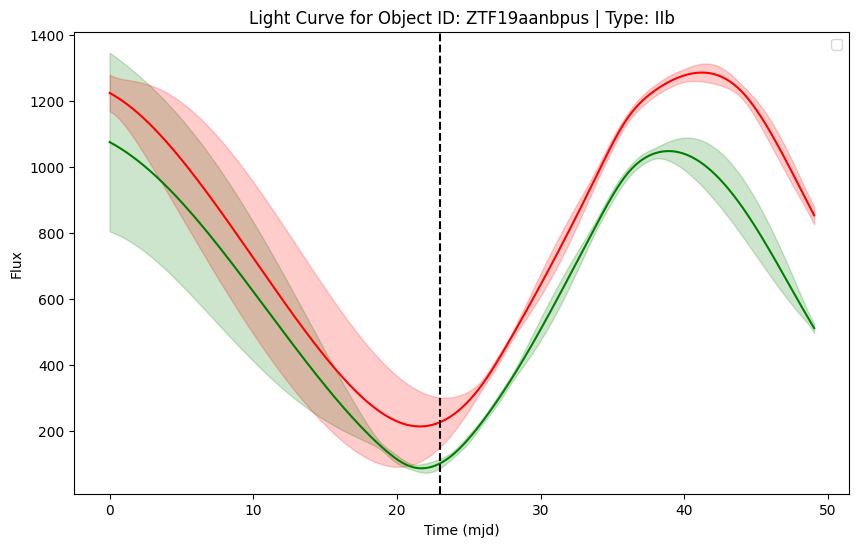

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


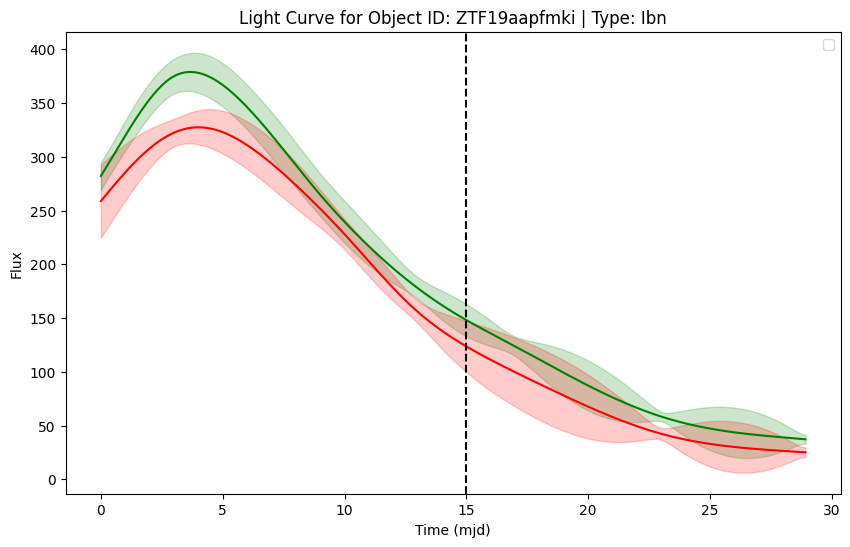

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


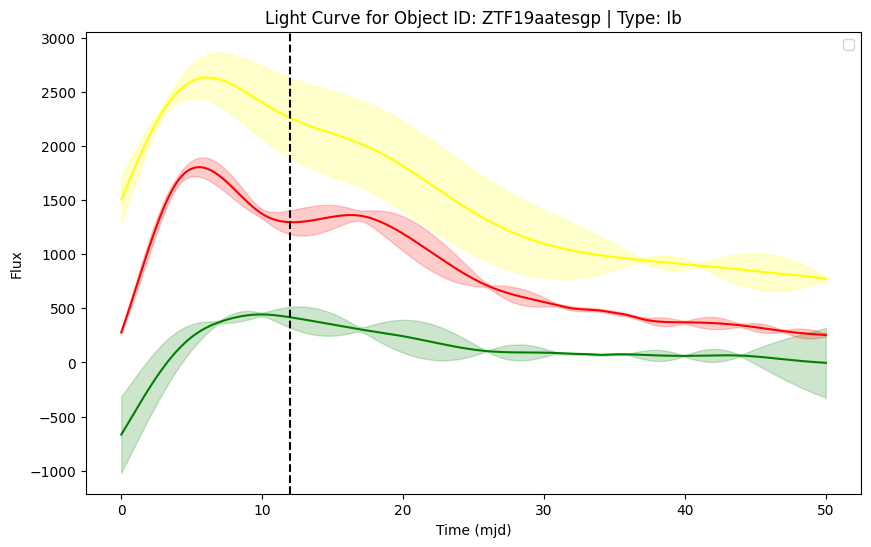

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


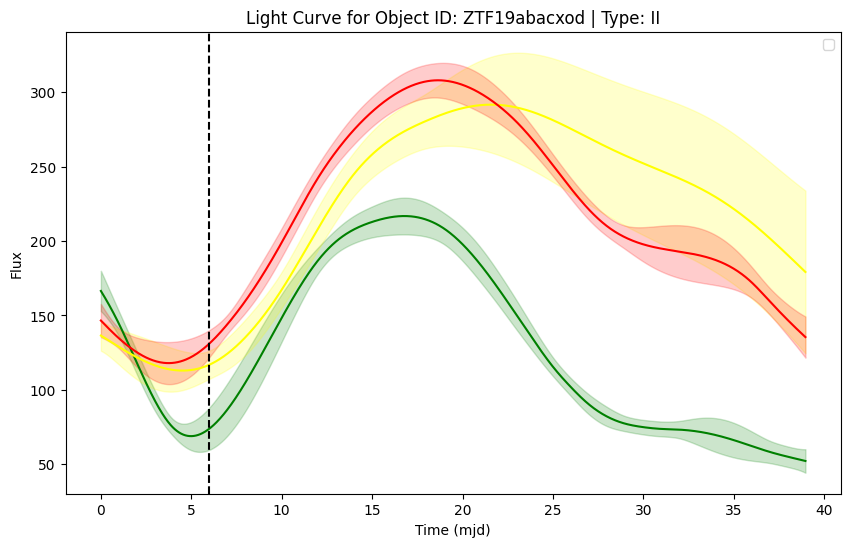

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


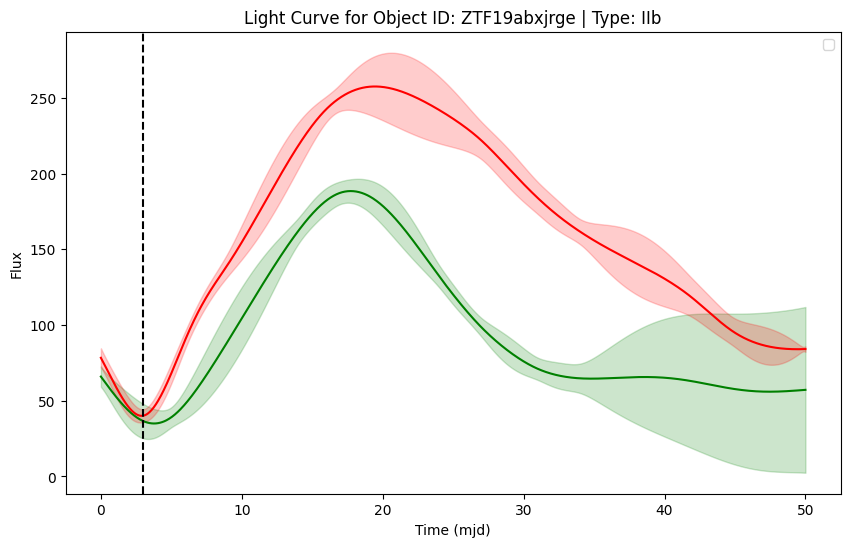

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


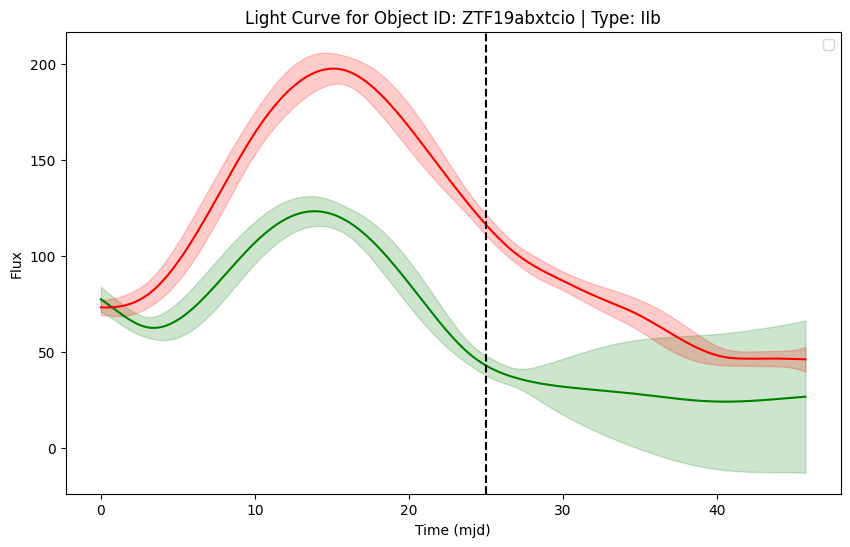

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


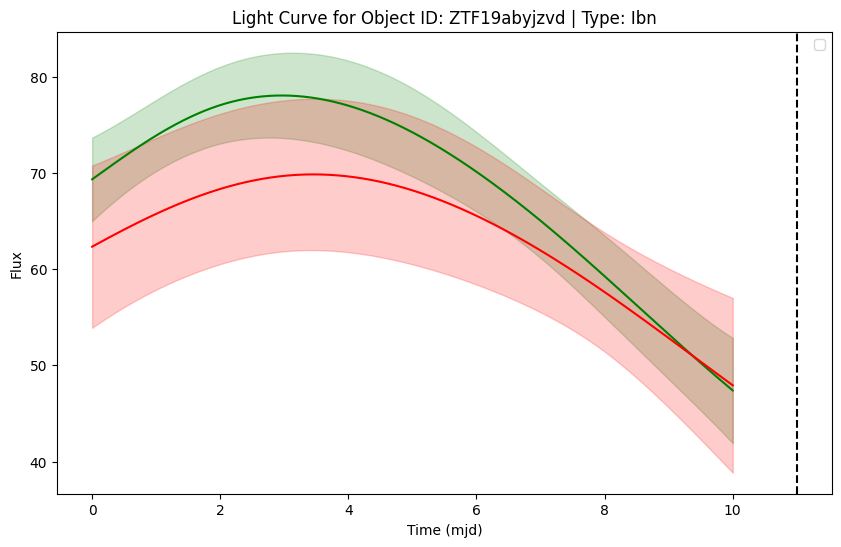

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


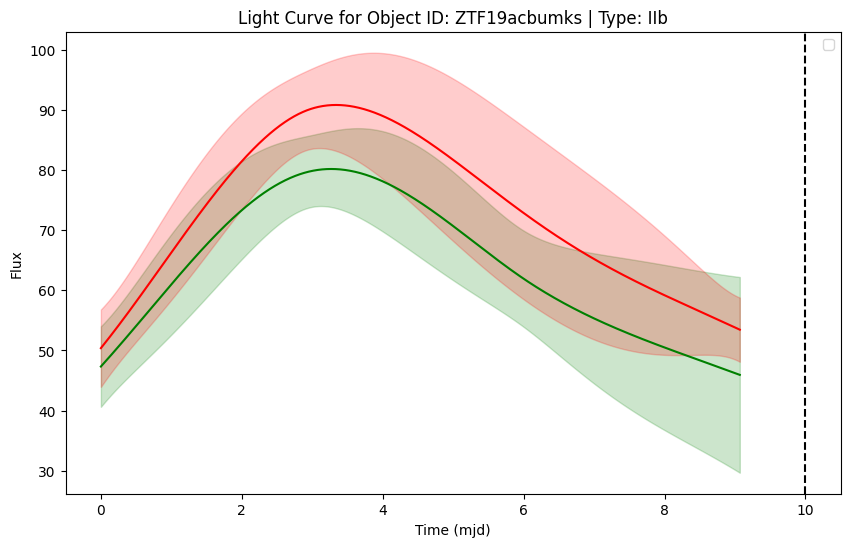

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


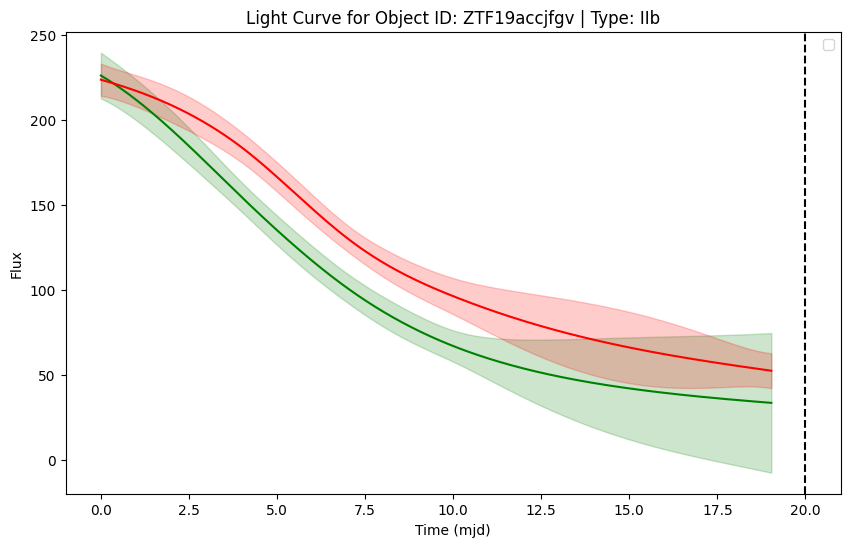

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


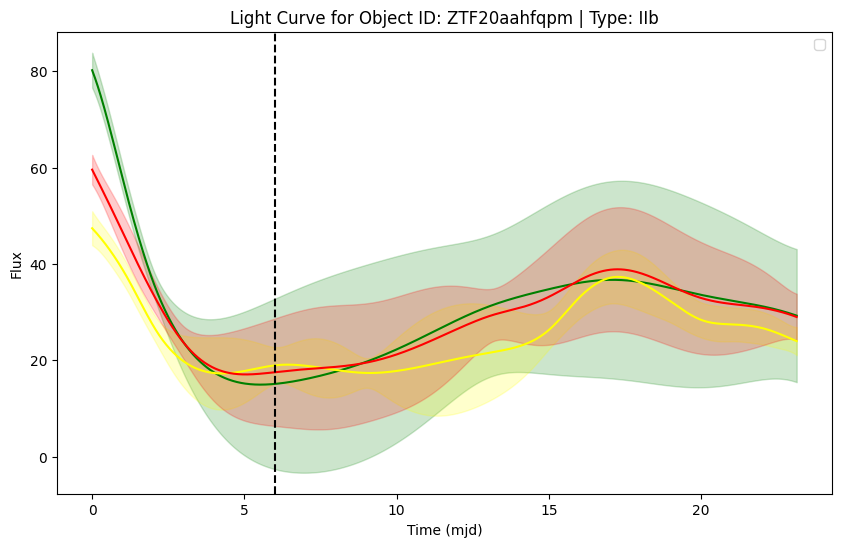

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


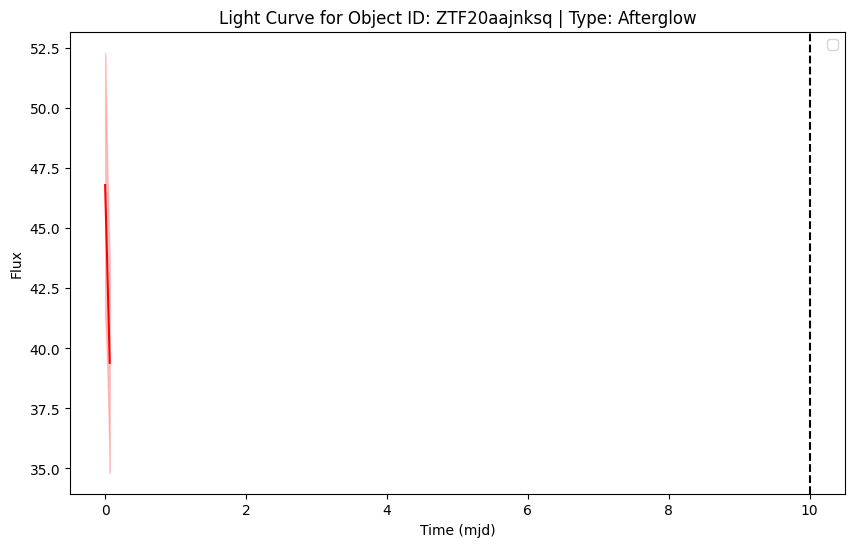

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


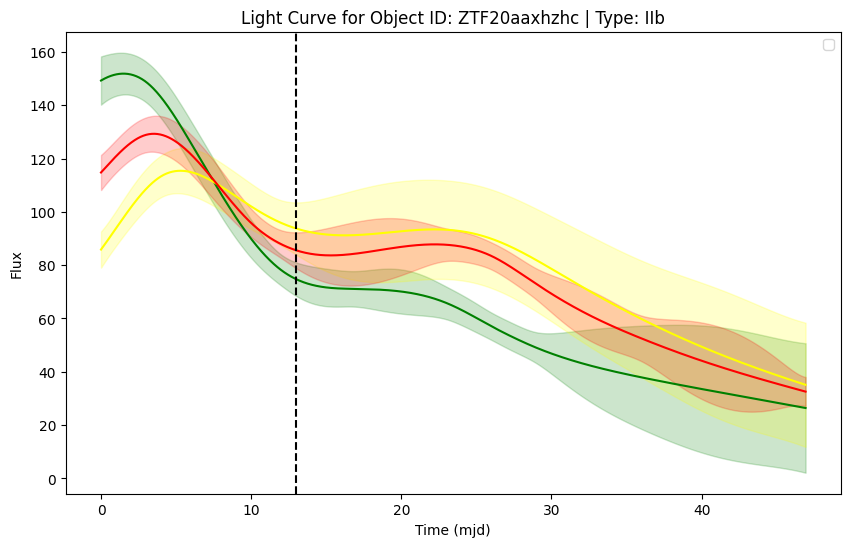

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


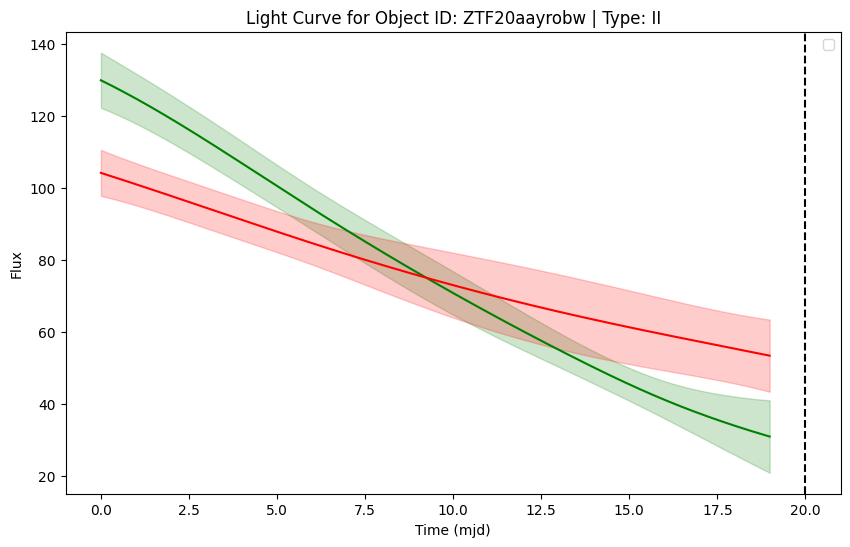

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


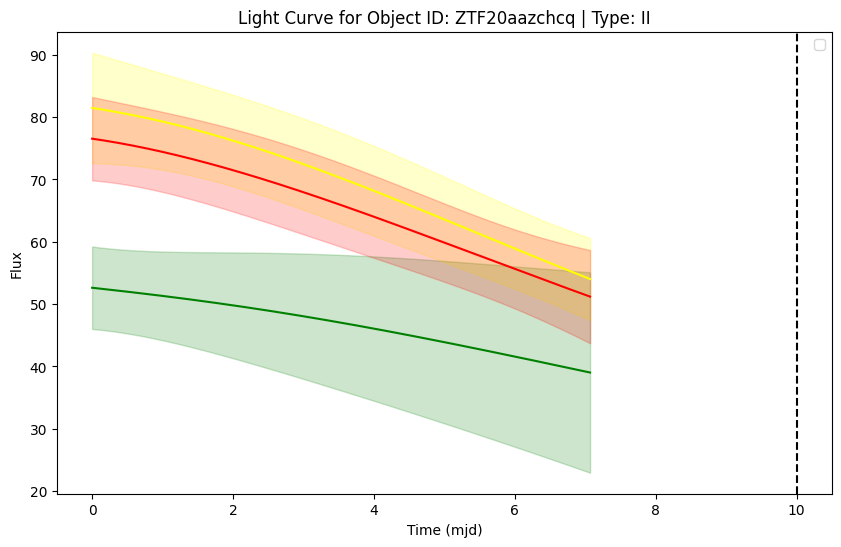

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


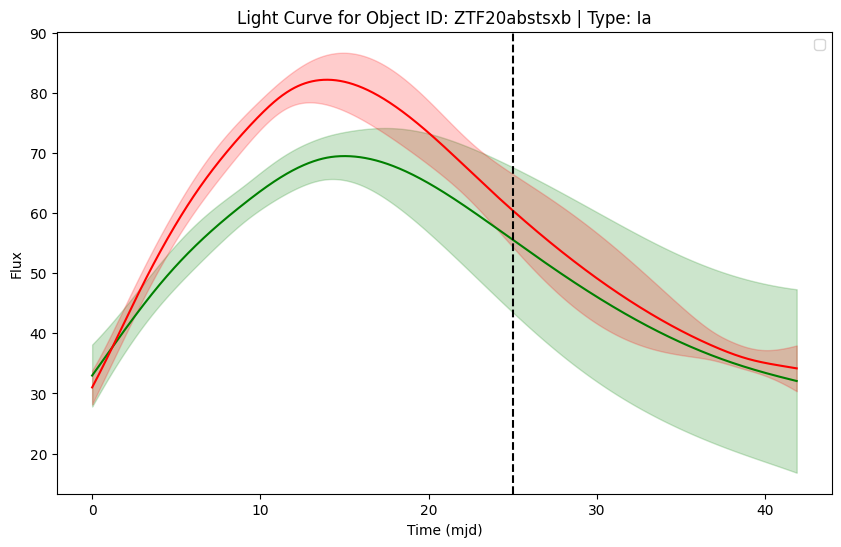

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


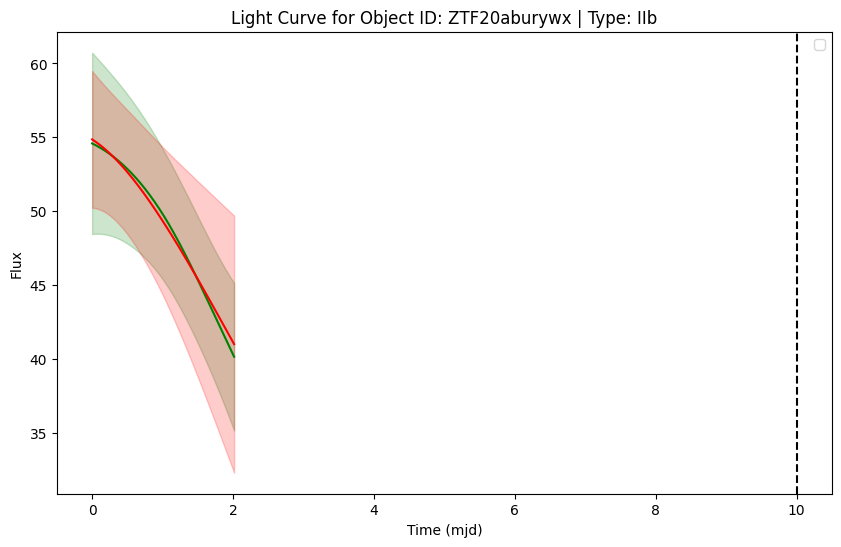

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


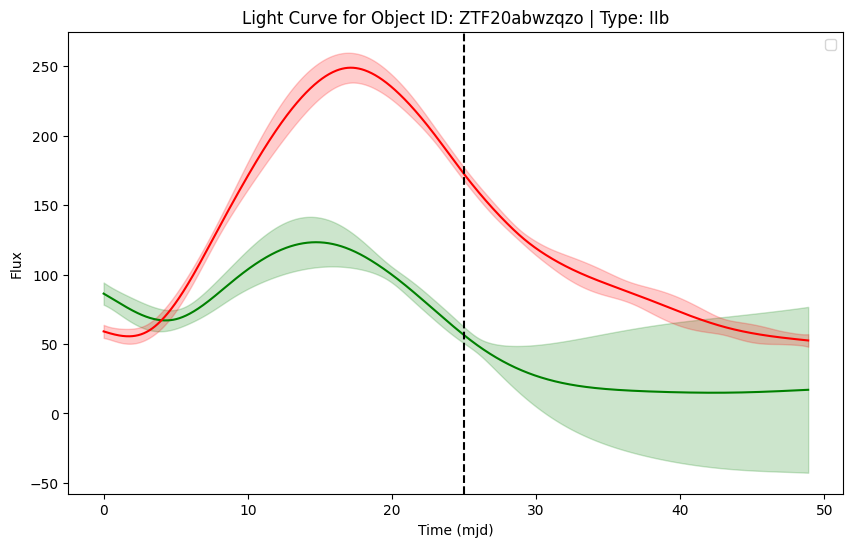

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


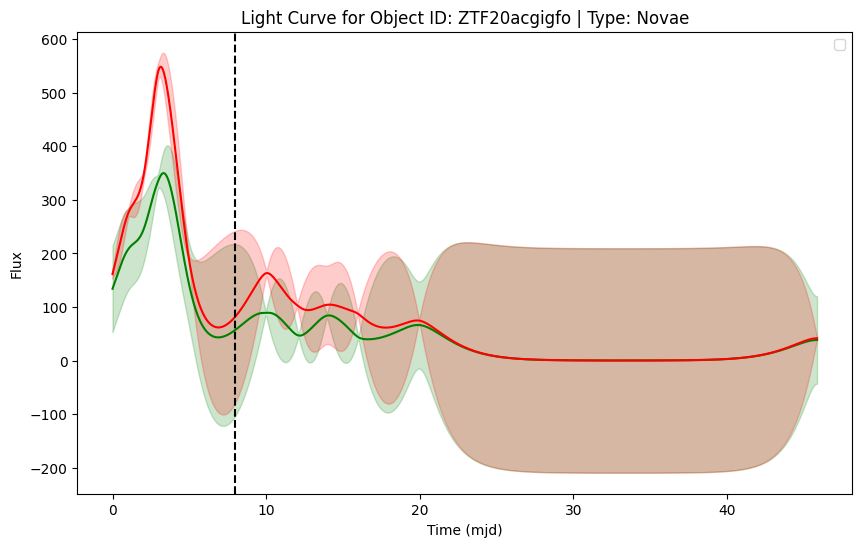

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


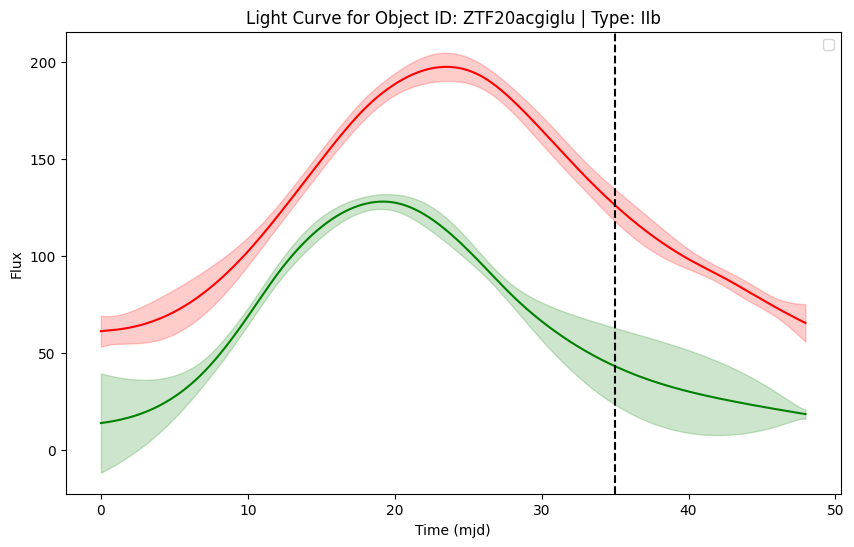

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


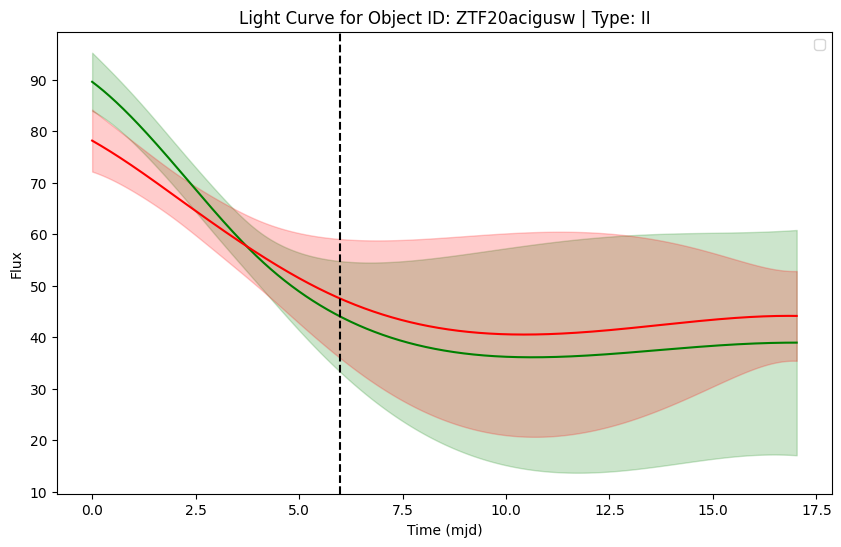

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


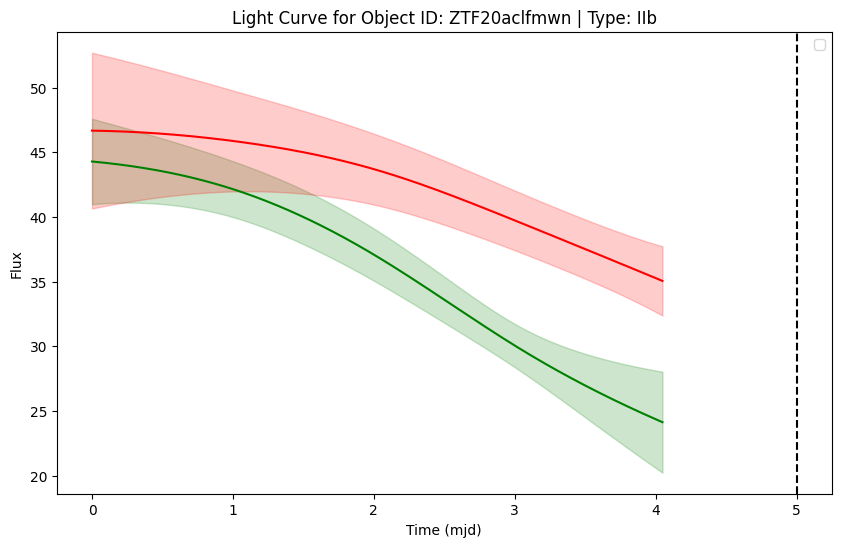

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


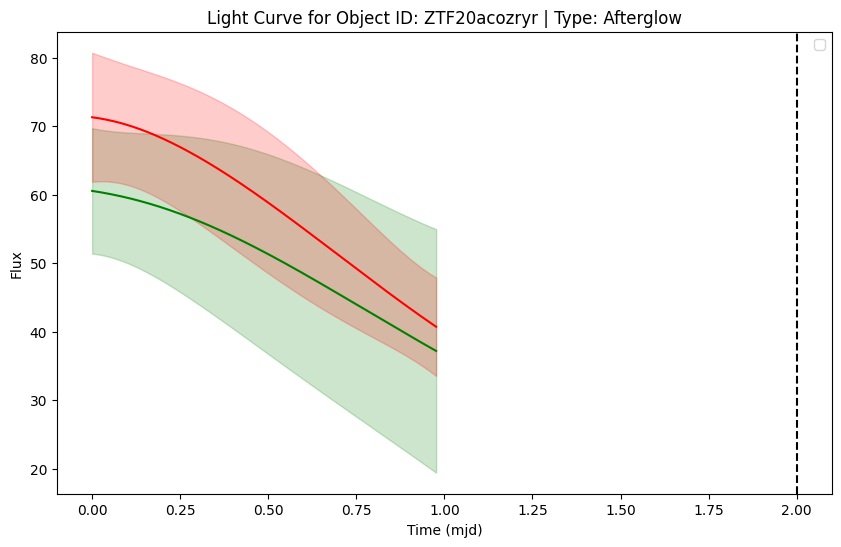

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


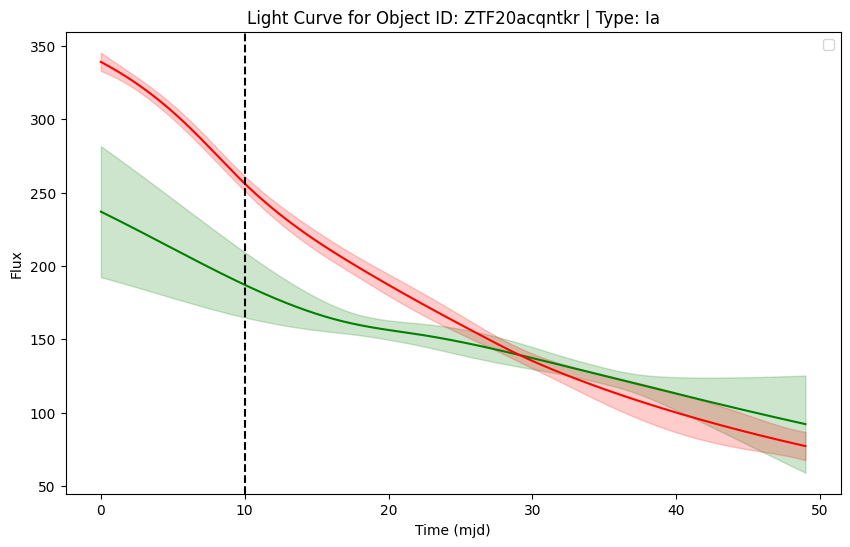

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


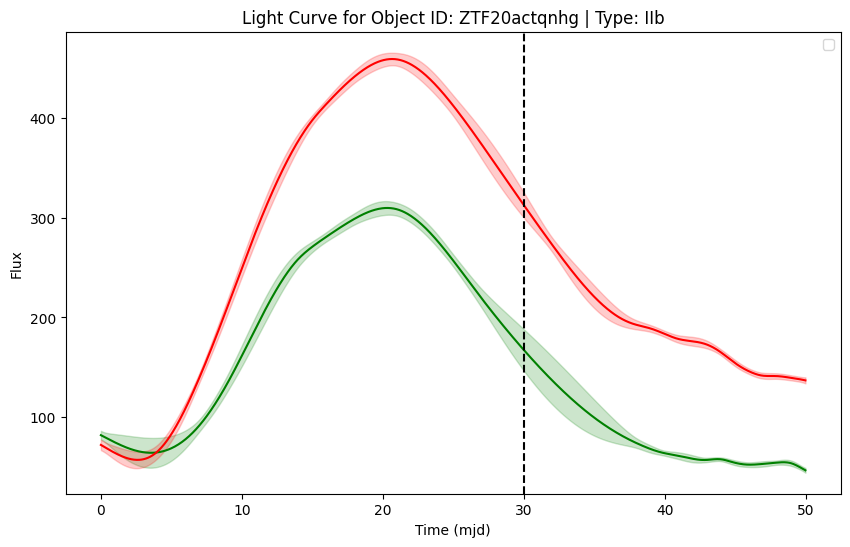

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


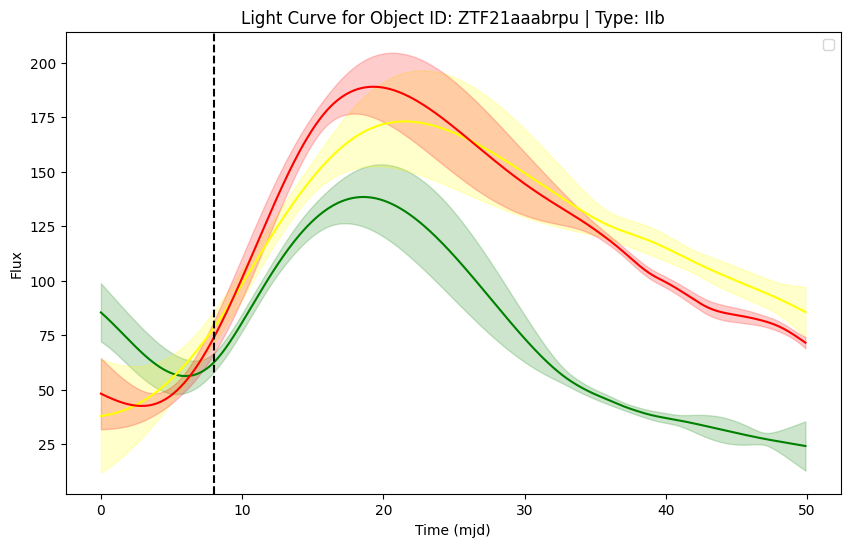

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


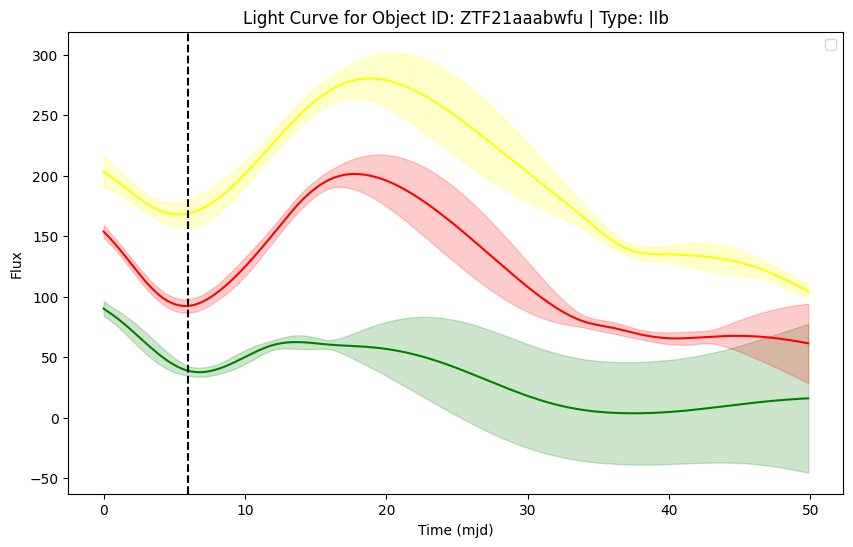

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


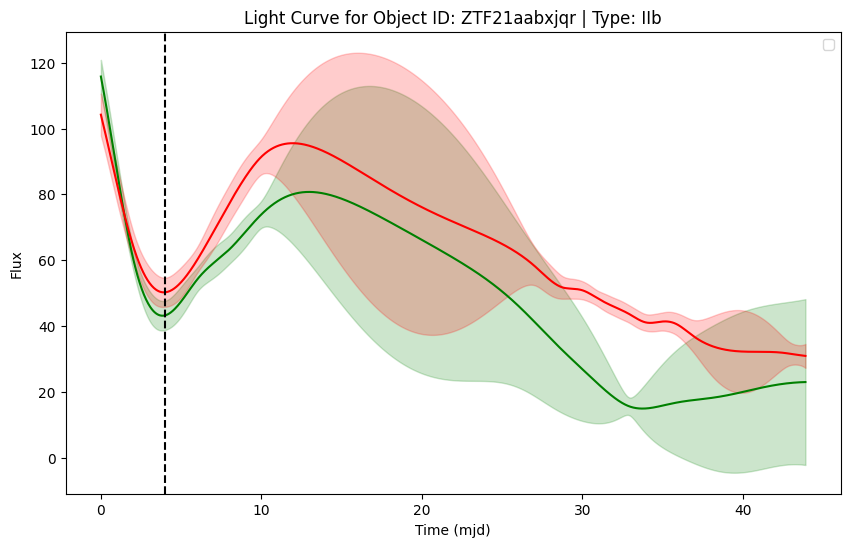

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


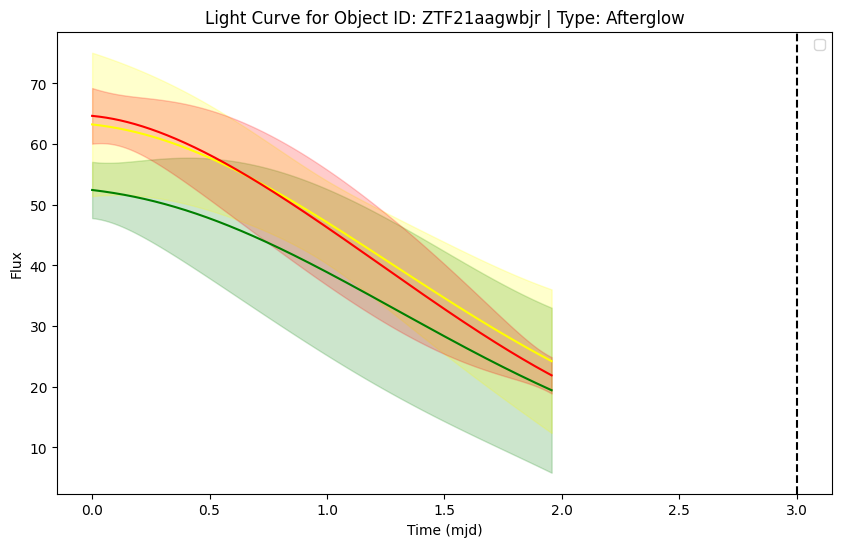

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


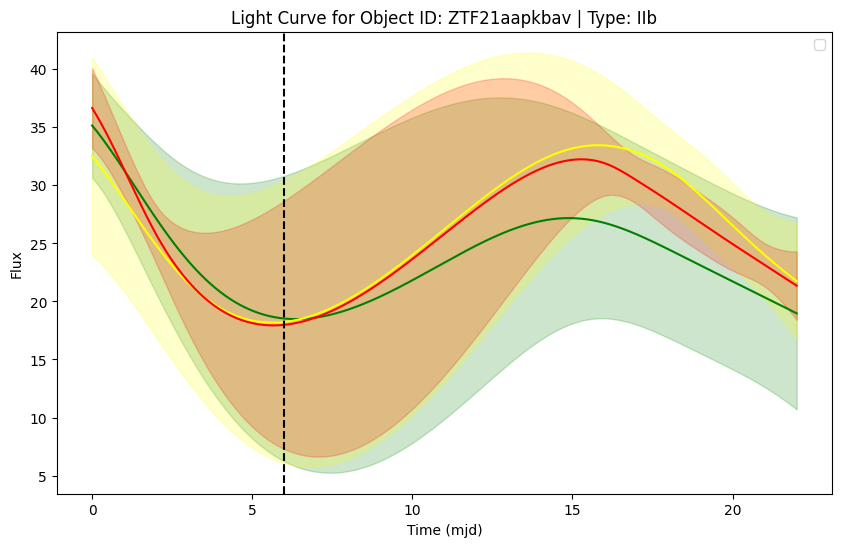

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


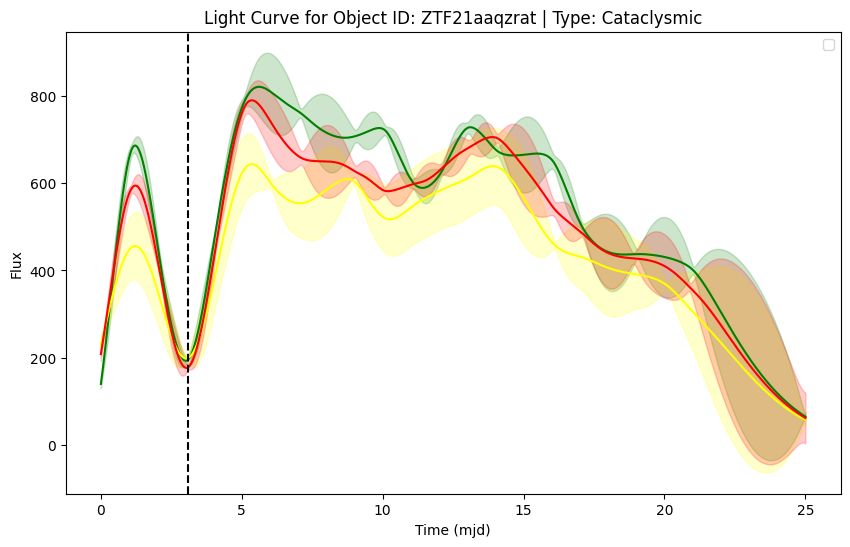

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


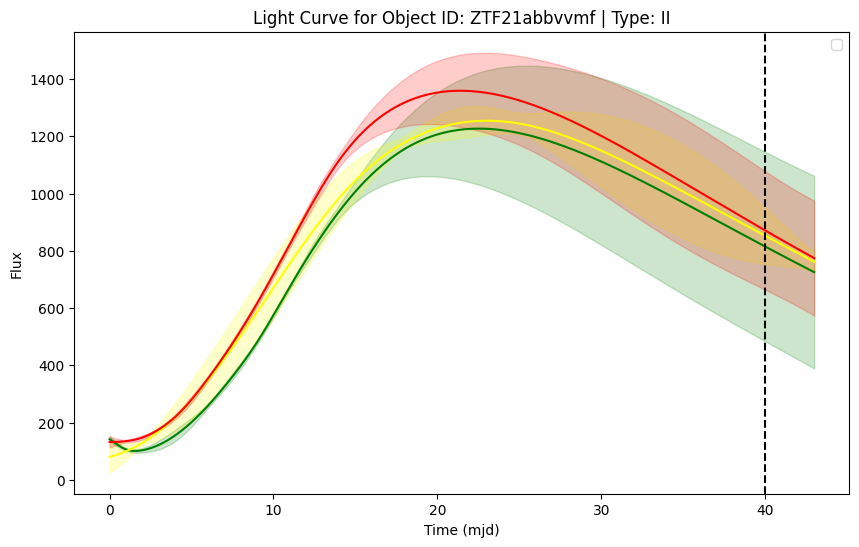

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


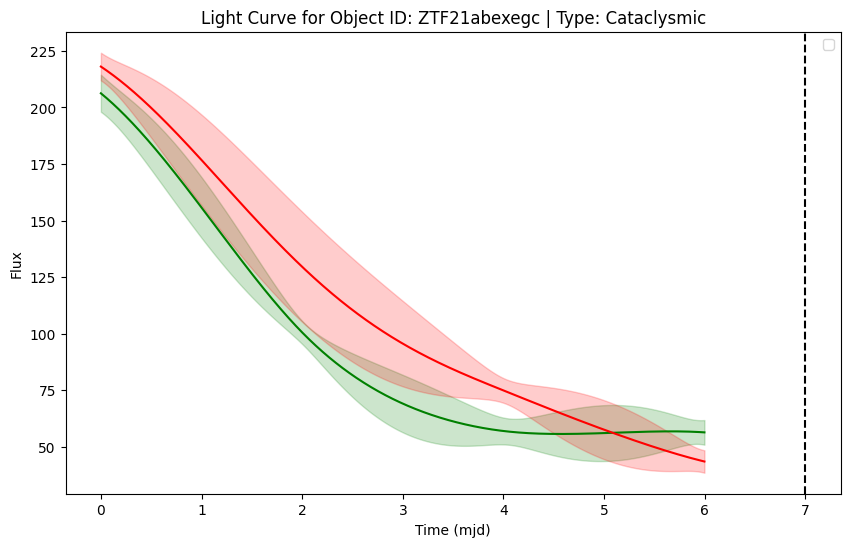

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


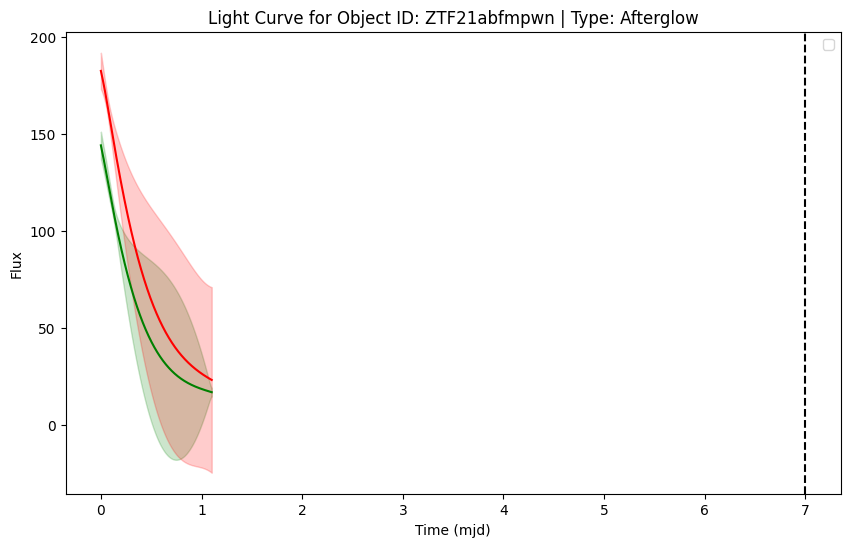

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


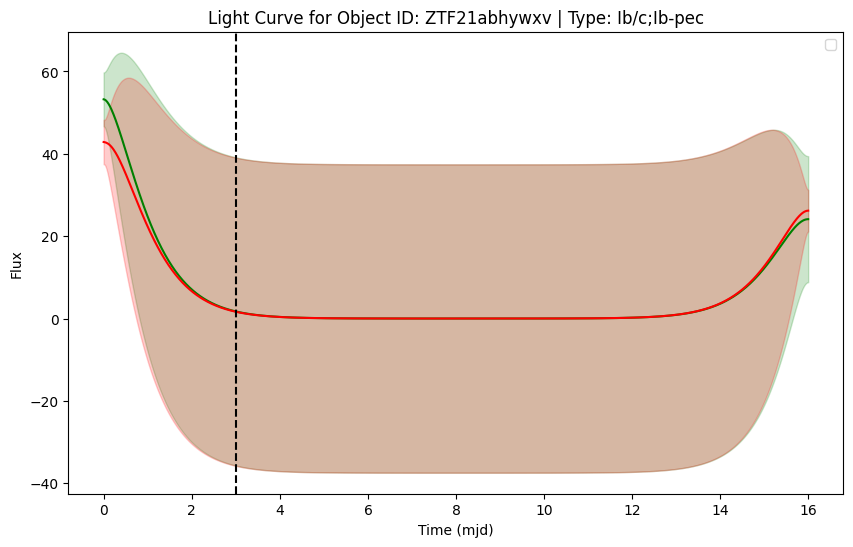

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


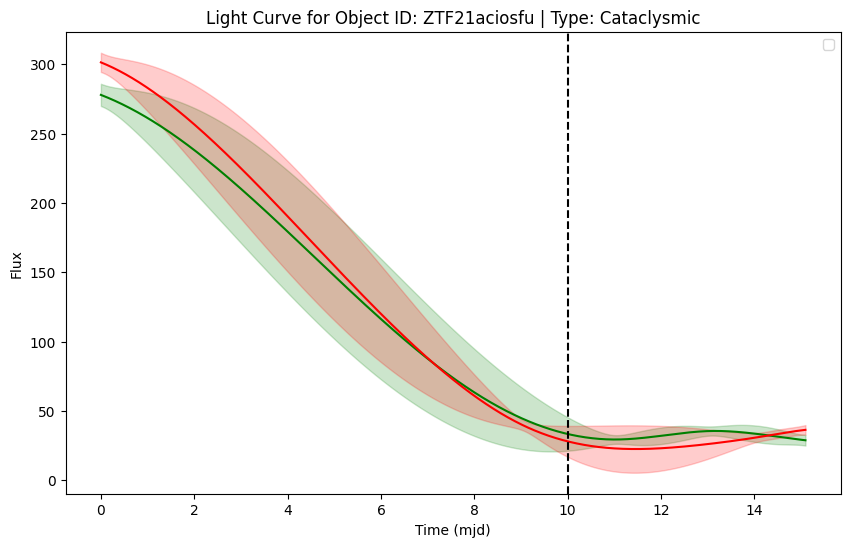

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


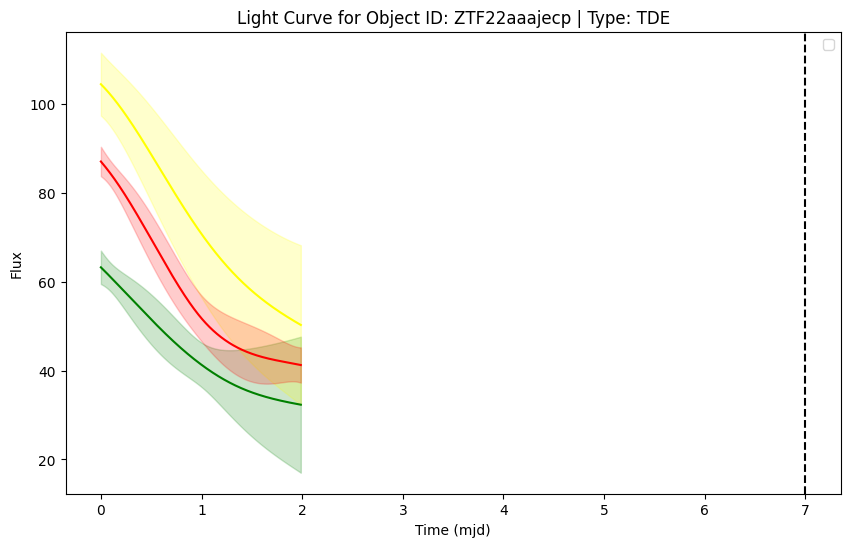

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


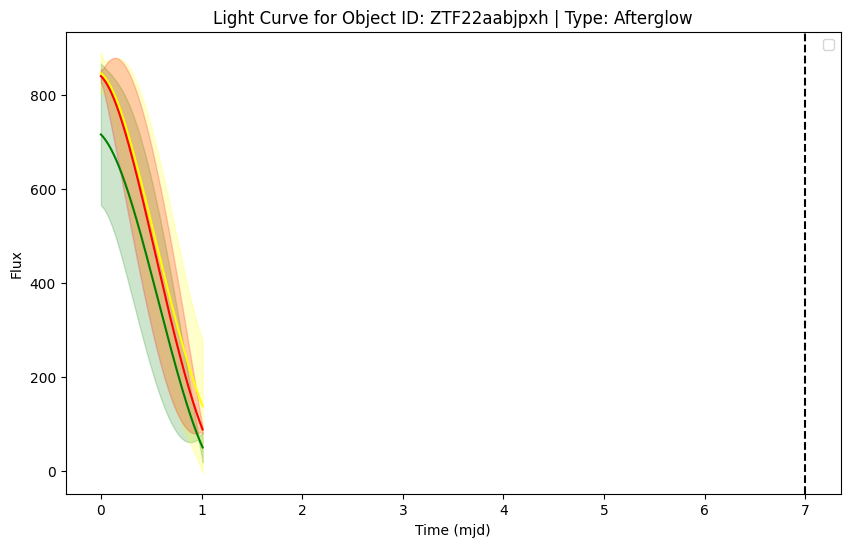

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


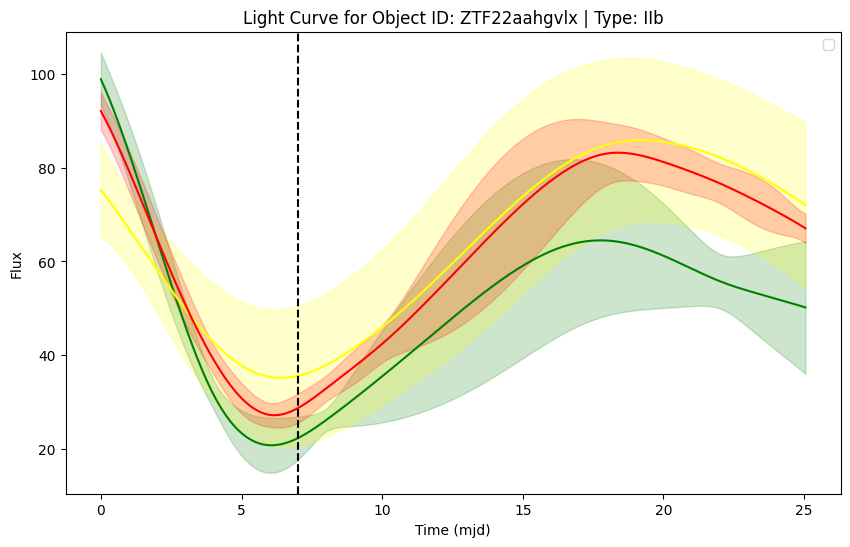

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


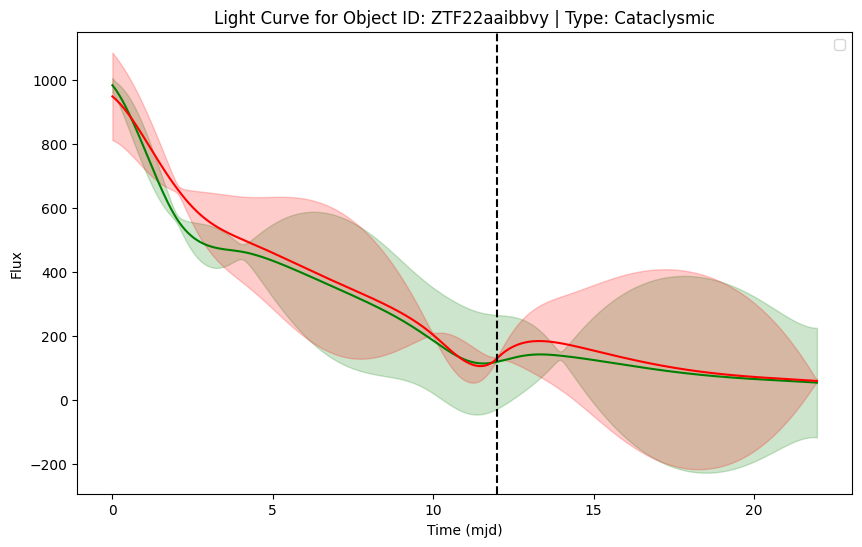

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


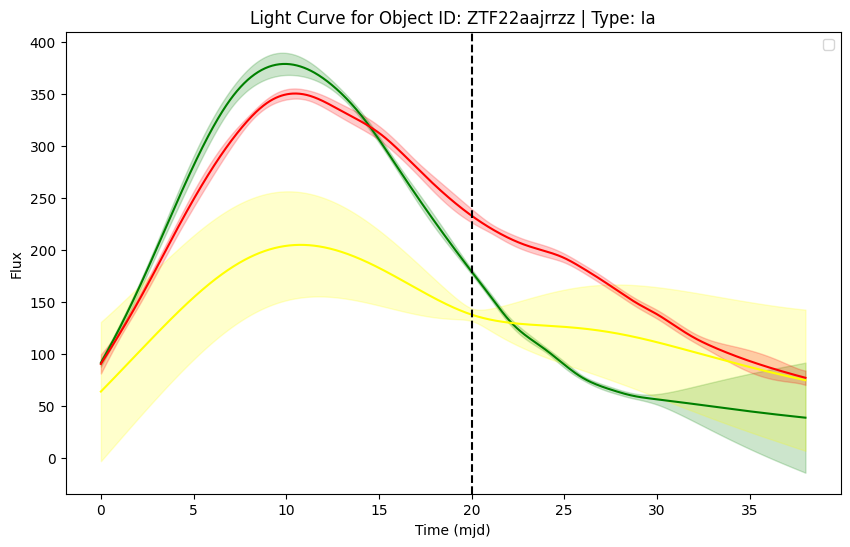

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


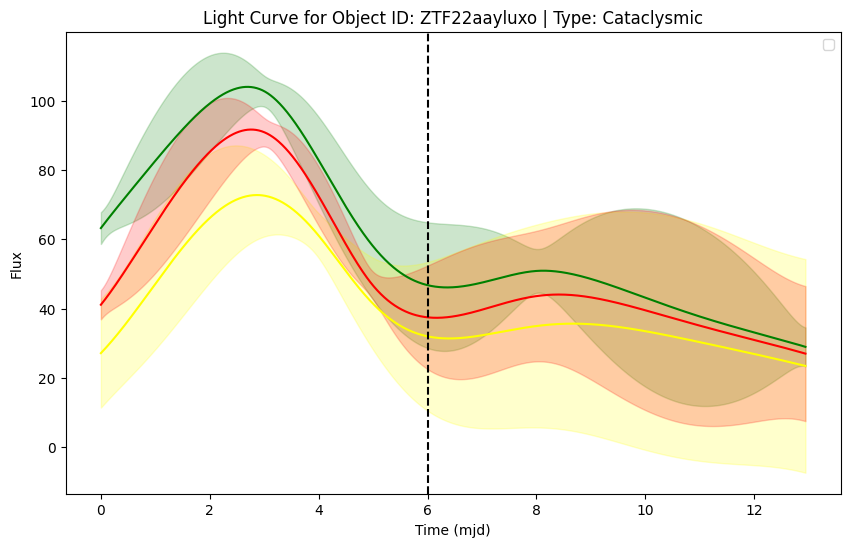

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


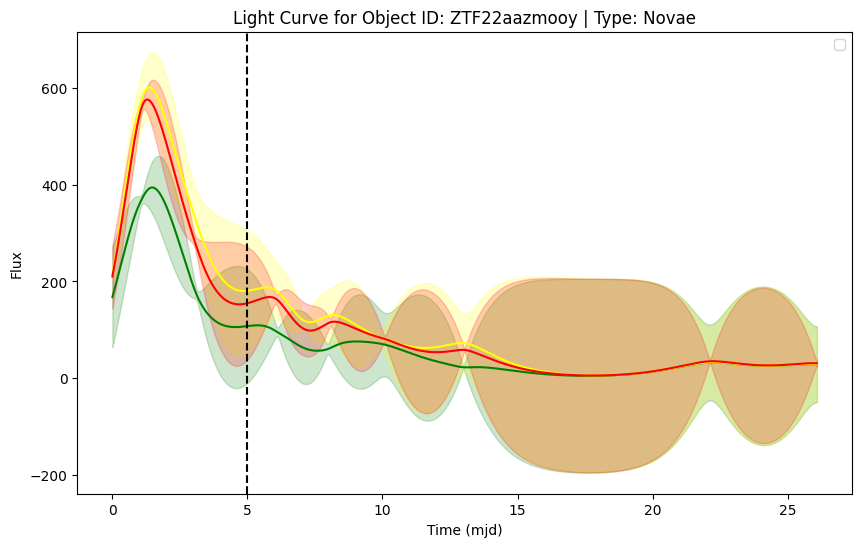

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


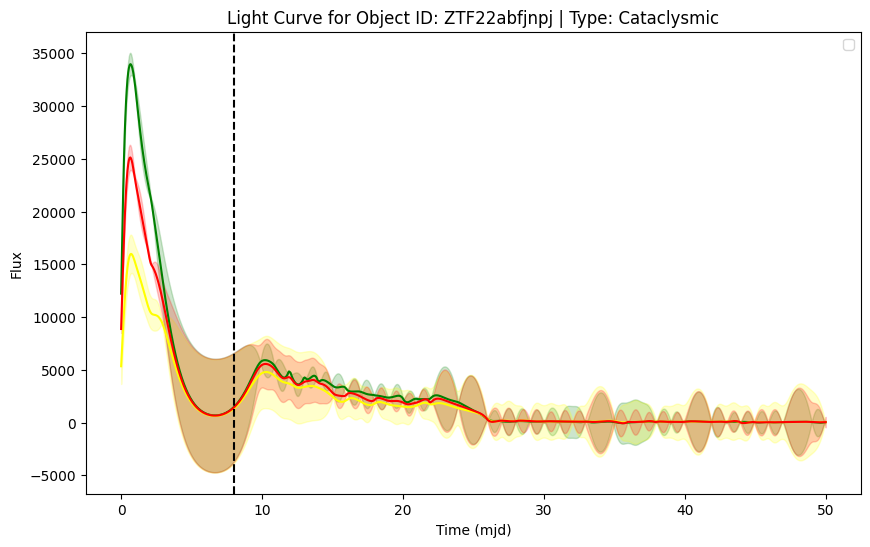

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


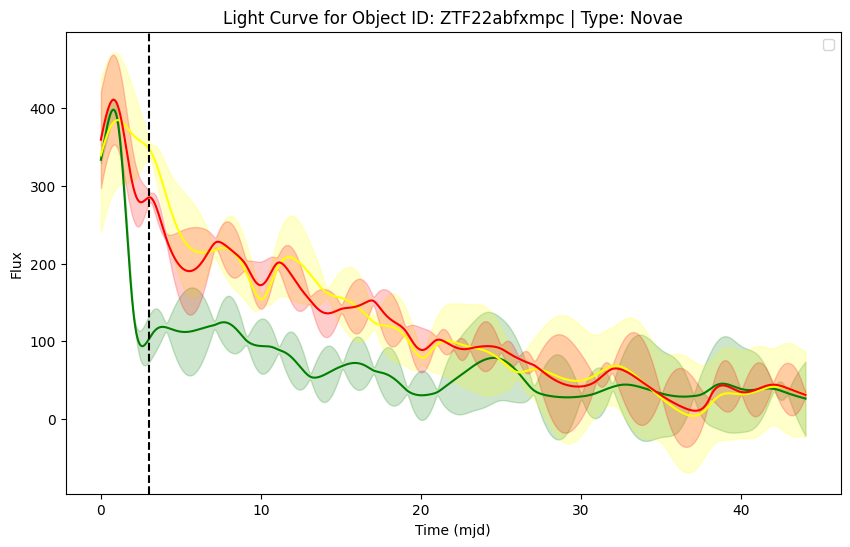

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


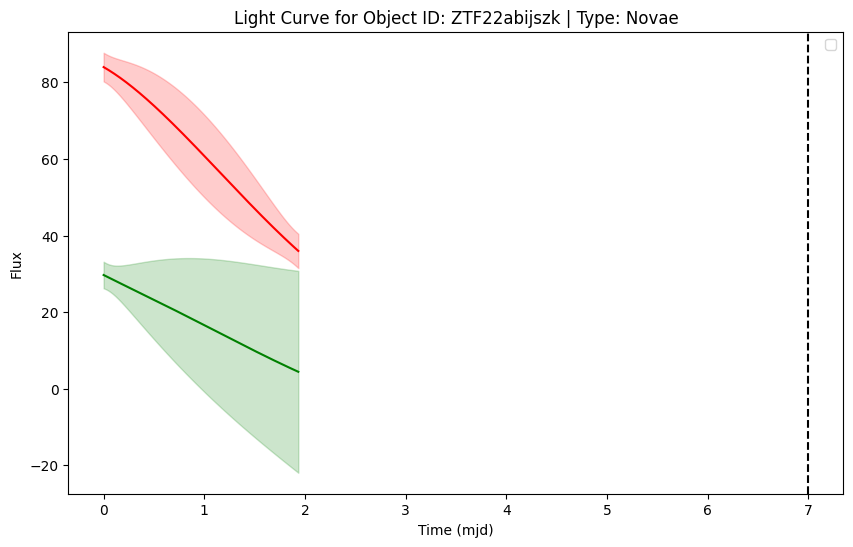

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


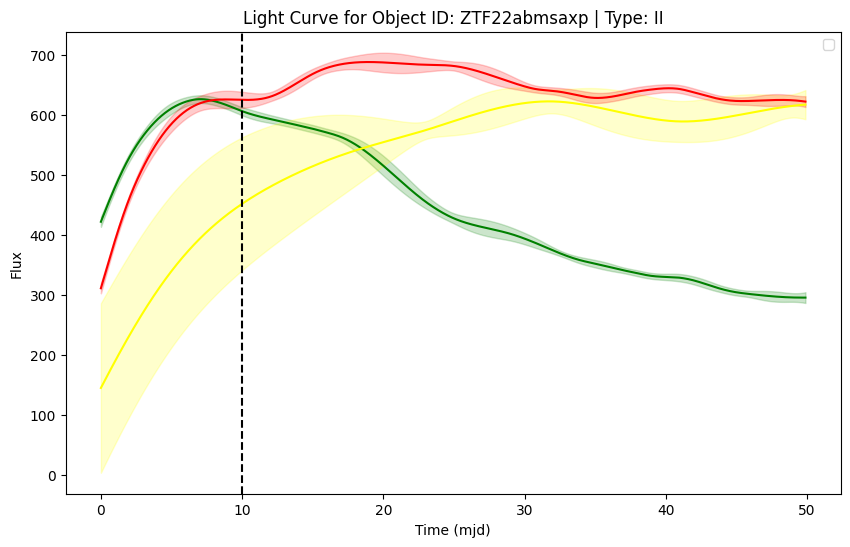

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


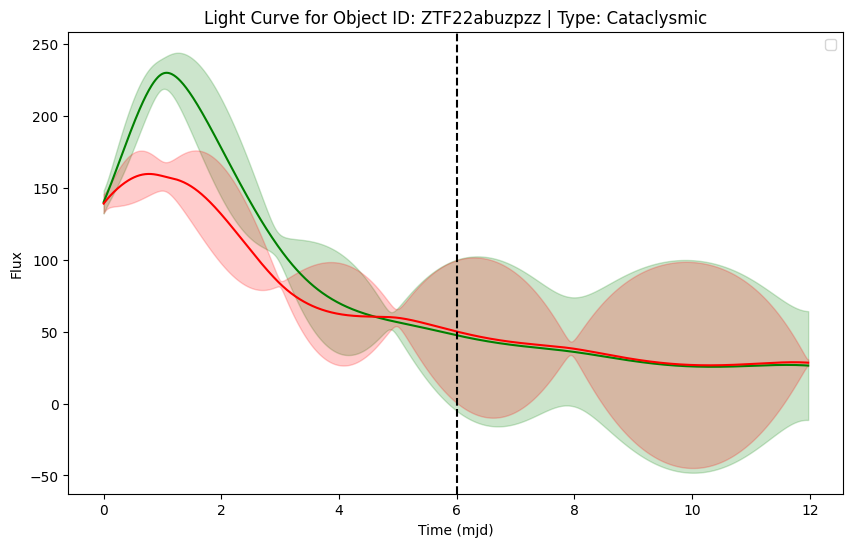

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


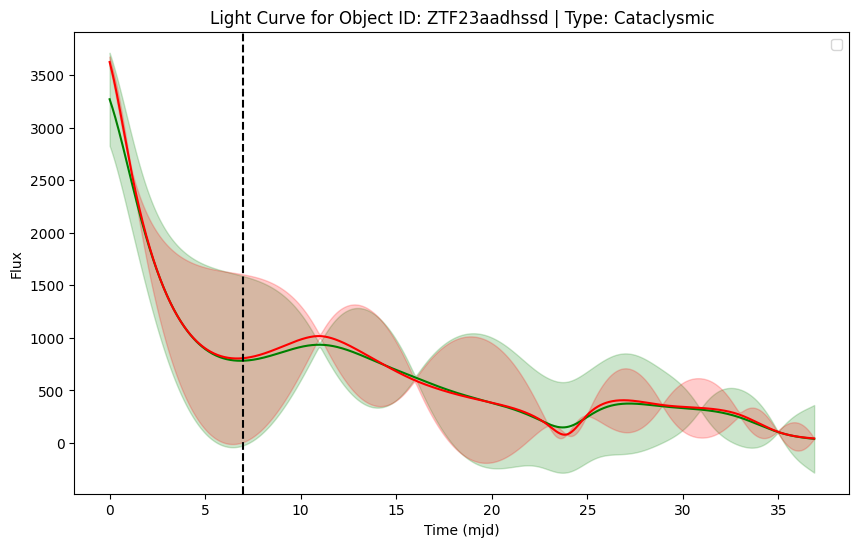

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


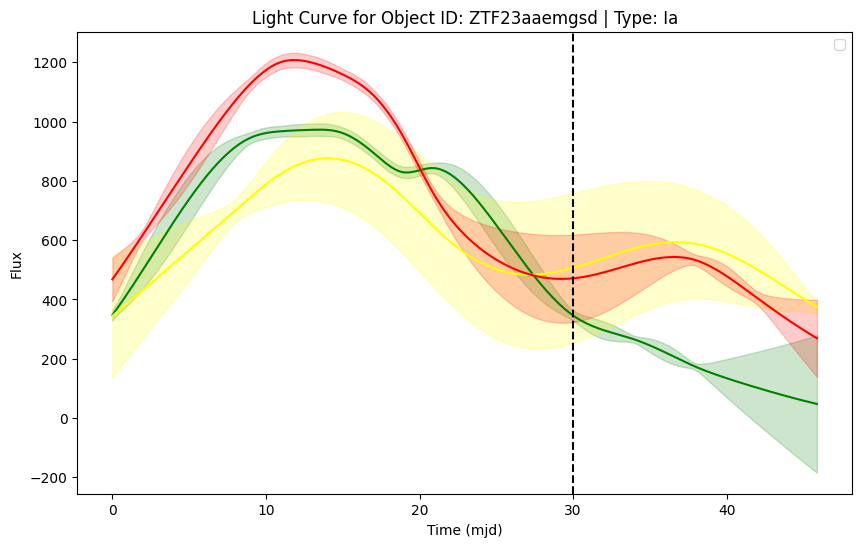

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


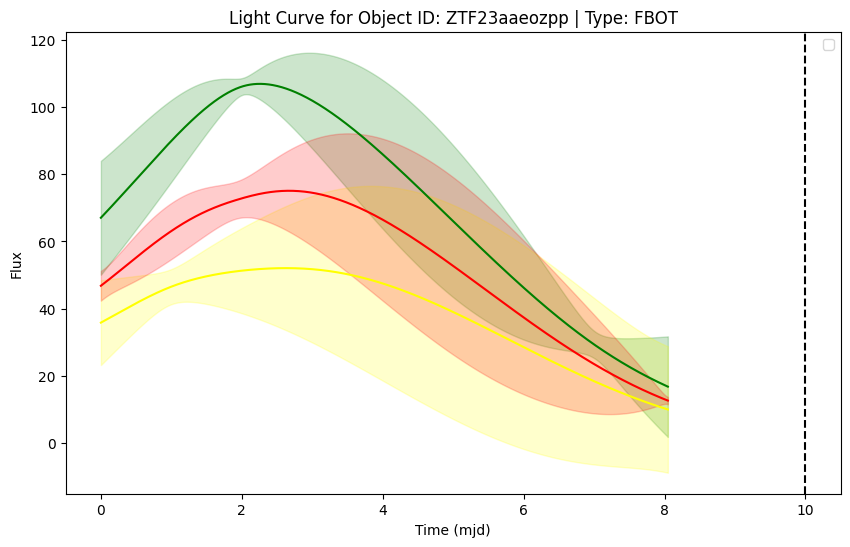

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


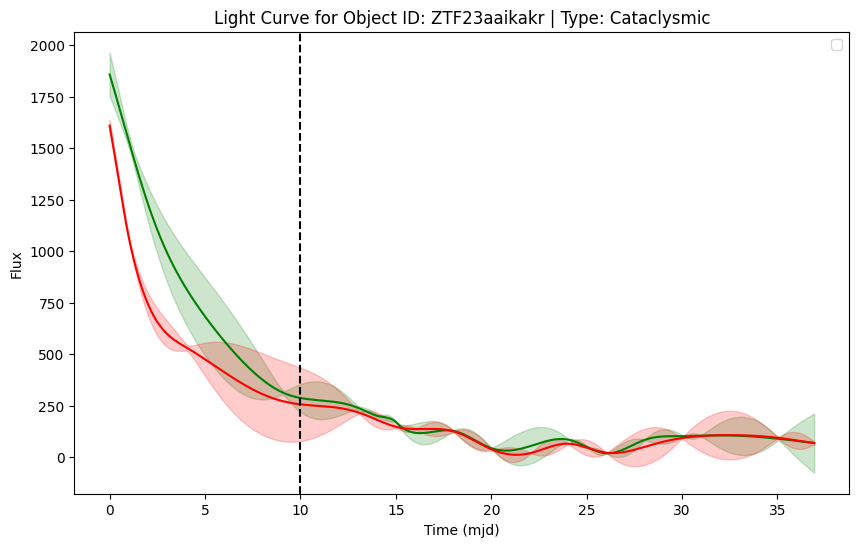

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


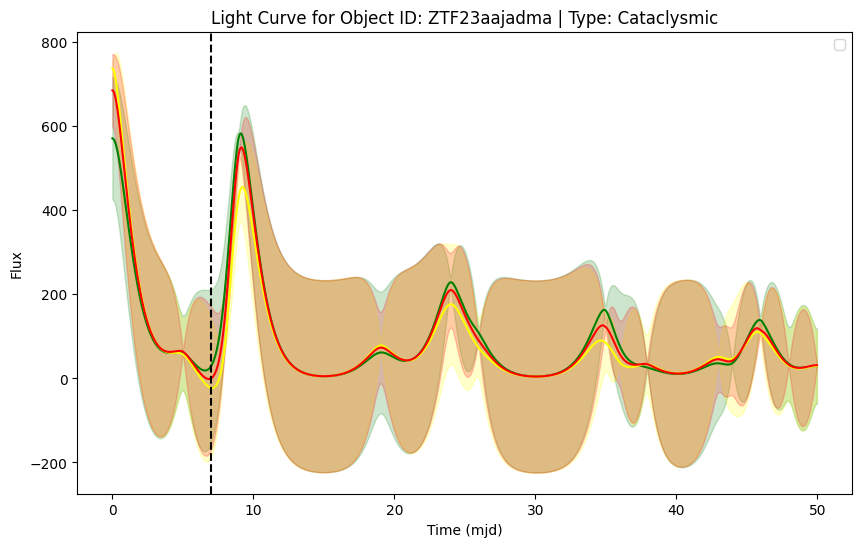

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


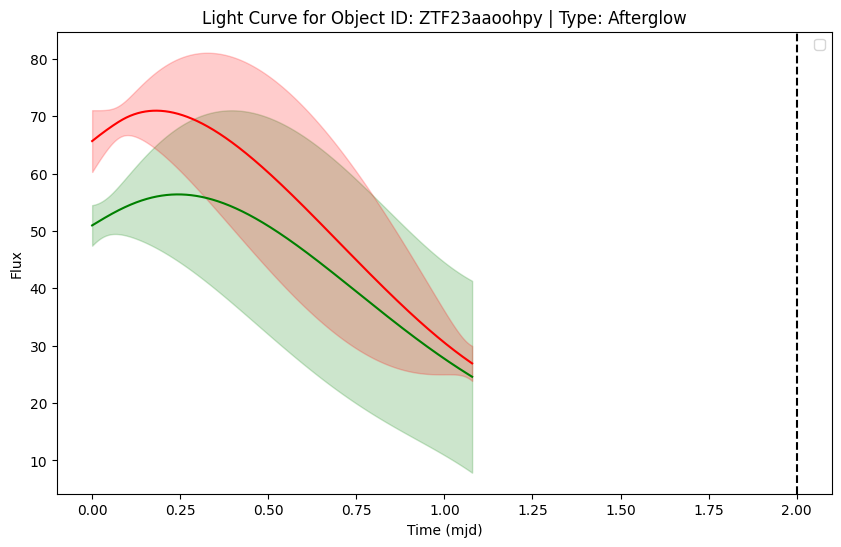

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


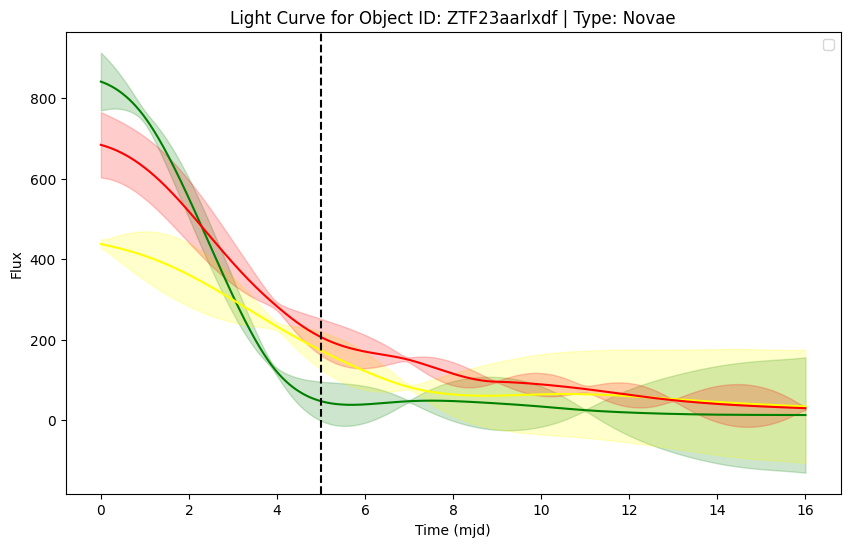

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


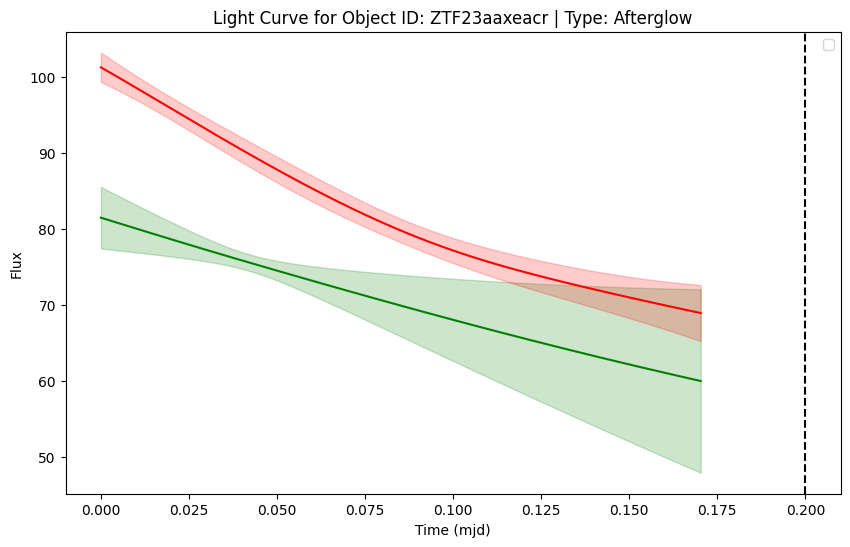

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


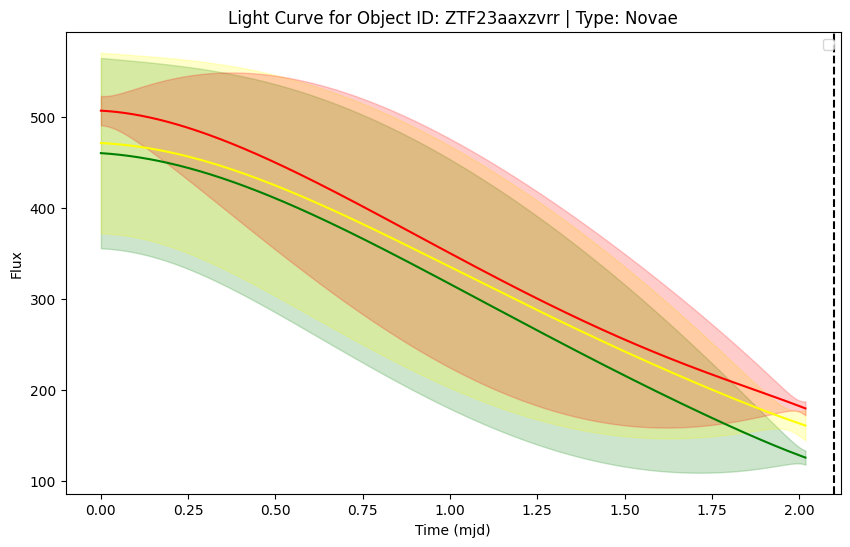

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


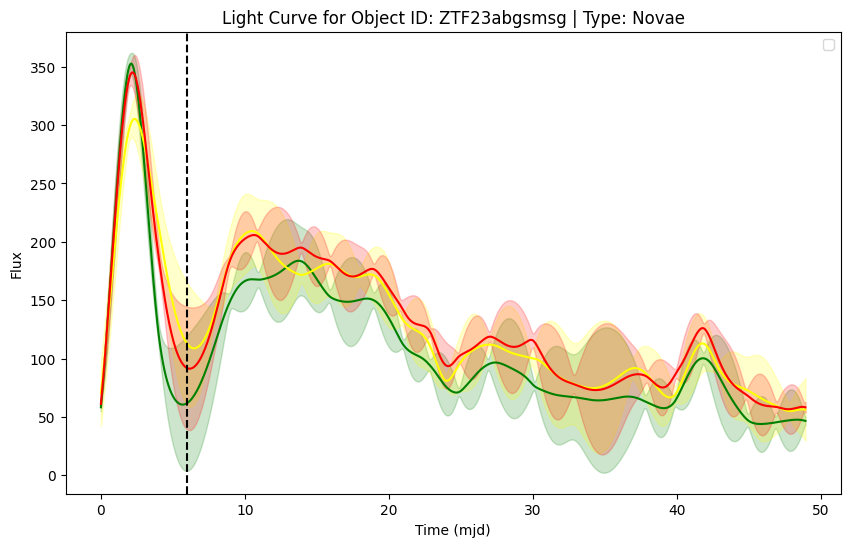

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


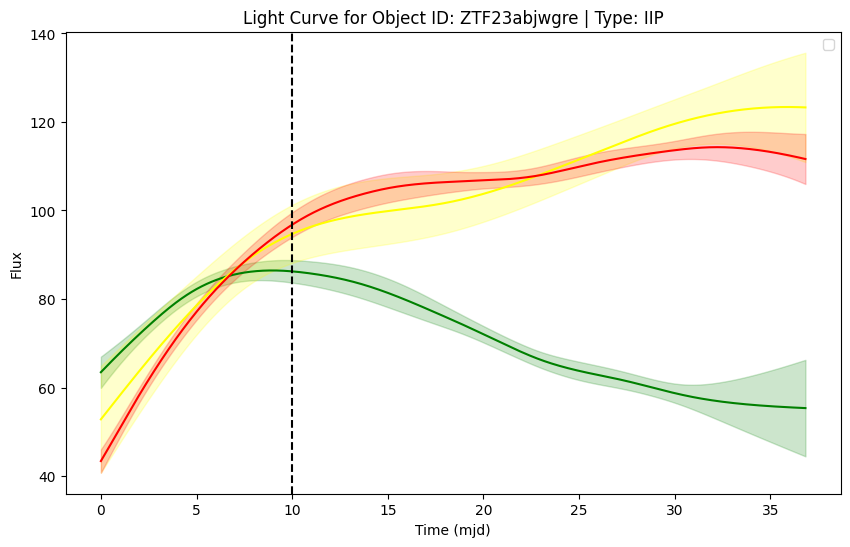

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


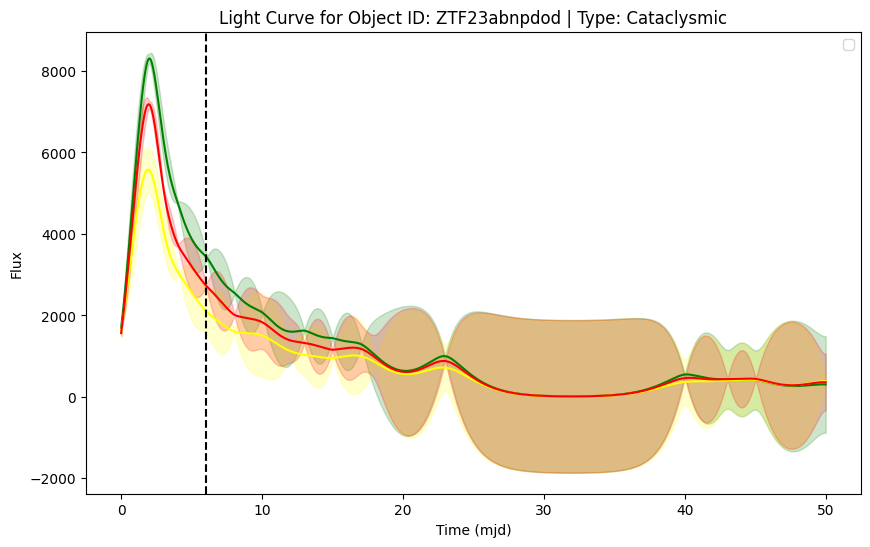

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


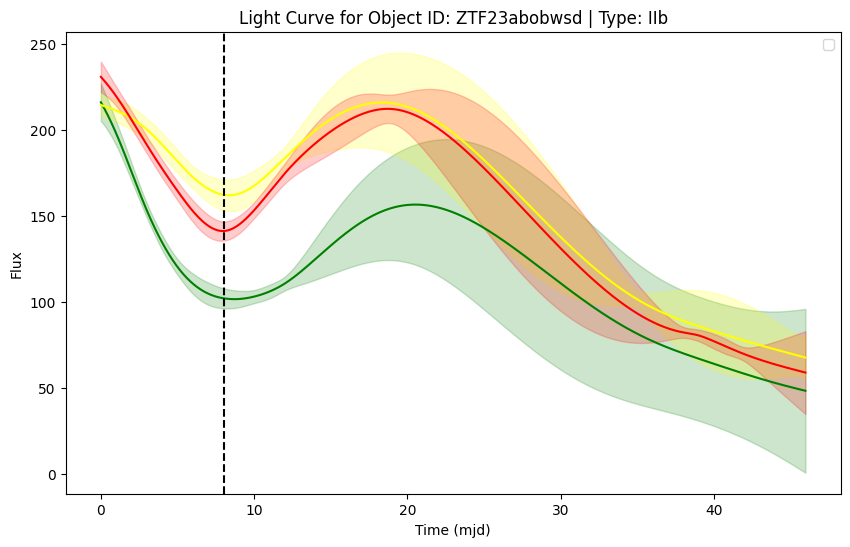

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


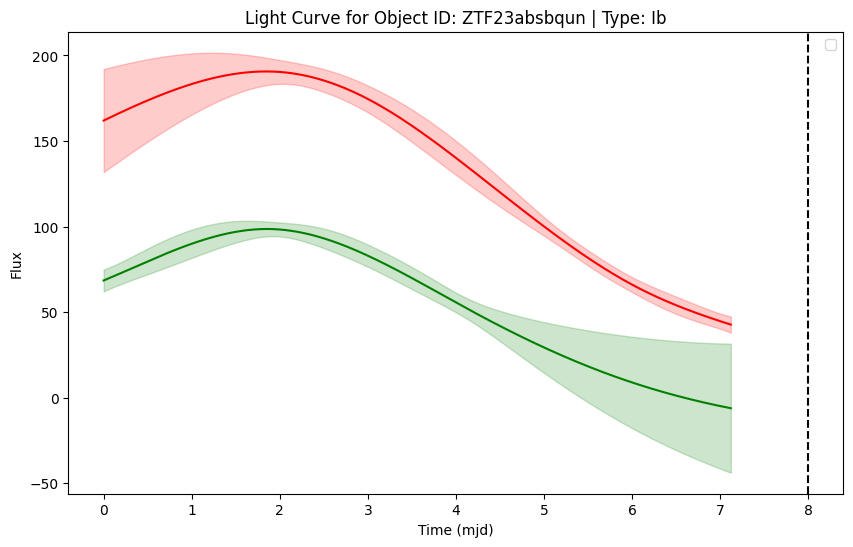

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


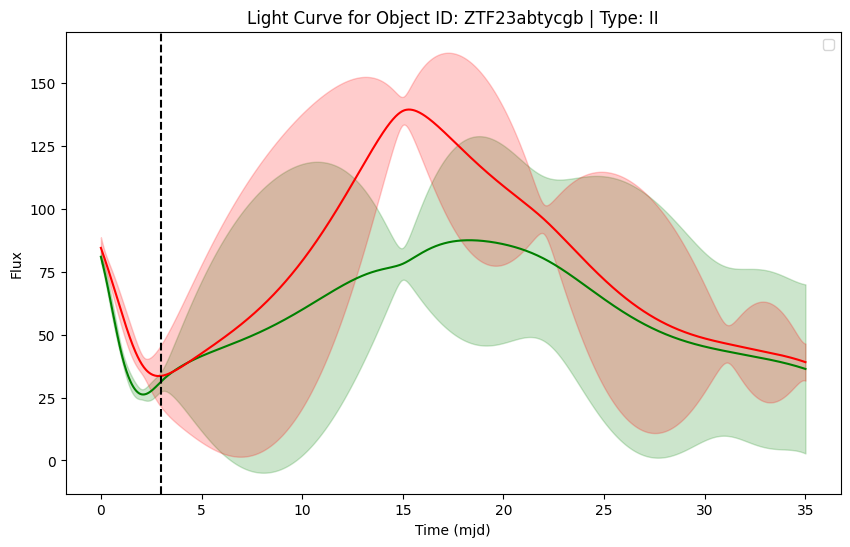

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


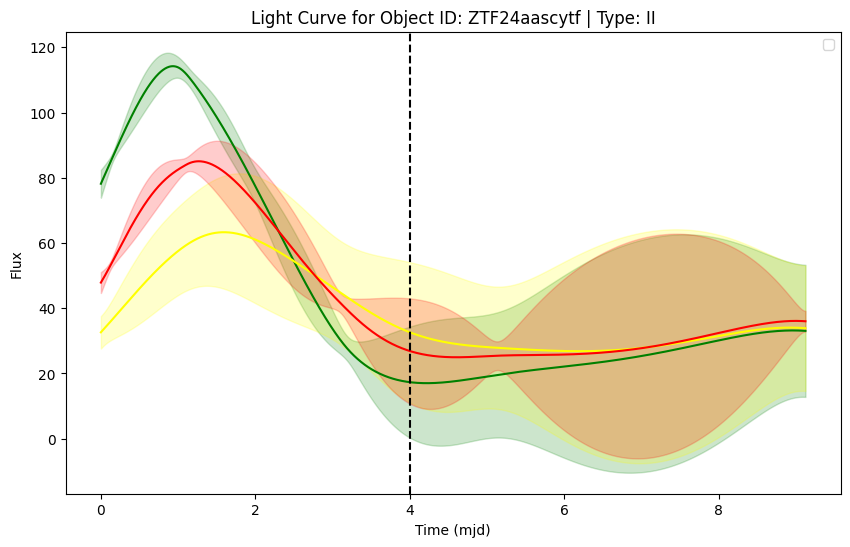

In [7]:
## really should make this less hacky
df = cut_data(df, obj[0], 10)
df = cut_data(df, obj[1], 15)
df = cut_data(df, obj[2], 7)
df = cut_data(df, obj[3], 10)
df = cut_data(df, obj[4], 12)
df = cut_data(df, obj[5], 12)
df = cut_data(df, obj[6], 23)
df = cut_data(df, obj[7], 15)
df = cut_data(df, obj[8], 12)
df = cut_data(df, obj[9], 6)
df = cut_data(df, obj[10], 3)
df = cut_data(df, obj[11], 25)
df = cut_data(df, obj[12], 11)
df = cut_data(df, obj[13], 10)
df = cut_data(df, obj[14], 20)
df = cut_data(df, obj[15], 6)
df = cut_data(df, obj[16], 10)
df = cut_data(df, obj[17], 13)
df = cut_data(df, obj[18], 20)
df = cut_data(df, obj[19], 10)
df = cut_data(df, obj[20], 25)
df = cut_data(df, obj[21], 10)
df = df[df['obj_id'] != obj[22]]  # ztfabwysqy not suited to GP
df = cut_data(df, obj[23], 25)
df = cut_data(df, obj[24], 8)
df = cut_data(df, obj[25], 35)
df = cut_data(df, obj[26], 6)
df = cut_data(df, obj[27], 5)
df = cut_data(df, obj[28], 2)
df = cut_data(df, obj[29], 10)
df = cut_data(df, obj[30], 30)
df = cut_data(df, obj[31], 8)
df = cut_data(df, obj[32], 6)
df = cut_data(df, obj[33], 4)
df = cut_data(df, obj[34], 3)
df = cut_data(df, obj[35], 6)
df = cut_data(df, obj[36], 3.1)
df = cut_data(df, obj[37], 40)
df = cut_data(df, obj[38], 7)
df = cut_data(df, obj[39], 7)
df = cut_data(df, obj[40], 3)
df = cut_data(df, obj[41], 10)
df = cut_data(df, obj[42], 7)
df = cut_data(df, obj[43], 7)
df = cut_data(df, obj[44], 7)
df = cut_data(df, obj[45], 12)
df = cut_data(df, obj[46], 20)
df = cut_data(df, obj[47], 6)
df = cut_data(df, obj[48], 5)
df = cut_data(df, obj[49], 8)
df = cut_data(df, obj[50], 3)
df = cut_data(df, obj[51], 7)
df = cut_data(df, obj[52], 10)
#df = cut_data(df,obj[52], 7) ## ZTF22abntkbk was bogus, so the index shifted
df = cut_data(df,obj[53], 6)
df = df[df['obj_id'] != obj[54]]
df = cut_data(df,obj[55], 7)
df = cut_data(df,obj[56], 30)
df = cut_data(df,obj[57], 10)
df = cut_data(df,obj[58], 10)
df = df[df['obj_id'] != obj[59]]
df = cut_data(df,obj[60], 7)
df = cut_data(df,obj[61], 2)
df = cut_data(df,obj[62], 5)
df = cut_data(df,obj[63], 0.2)
df = cut_data(df,obj[64], 2.1)
df = cut_data(df,obj[65], 6)
df = cut_data(df,obj[66], 10)
df = cut_data(df,obj[67], 6)
df = cut_data(df,obj[68], 8)
df = df[df['obj_id'] != obj[69]]
df = cut_data(df,obj[70], 8)
df = cut_data(df,obj[71], 3)
df = cut_data(df,obj[72], 4)


In [8]:
df[df['obj_id'] == obj[-1]]

mjd  flux_ztfg  flux_ztfi  flux_ztfr  flux_error_ztfg  \
72001  60646.432303  36.331010        NaN  25.066002         2.034971   
72002  60646.438415  36.878915        NaN  25.505385         1.897780   
72003  60646.444527  37.431393        NaN  25.949203         1.804559   
72004  60646.450639  37.987503        NaN  26.397472         1.755290   
72005  60646.456751  38.546301        NaN  26.850209         1.748509   
...             ...        ...        ...        ...              ...   
72996  60652.513689  33.493383        NaN  40.961798         3.488673   
72997  60652.519801  33.463261        NaN  40.930338         3.842217   
72998  60652.525913  33.432509        NaN  40.895906         4.235472   
72999  60652.532025  33.401076        NaN  40.858402         4.657035   
73000  60652.538137  33.368917        NaN  40.817727         5.098662   

       flux_error_ztfi  flux_error_ztfr type        obj_id         mjd_0  ...  \
72001              NaN         3.157210  IIb  ZTF24abvevzs  60646.432303  ...   
72002              NaN         2.788540  IIb  ZTF24abvevzs  60646.432303  ...   
72003              NaN         2.448082  IIb  ZTF24abvevzs  60646.432303  ...   
72004              NaN         2.151762  IIb  ZTF24abvevzs  60646.432303  ...   
72005              NaN         1.923001  IIb  ZTF24abvevzs  60646.432303  ...   
...                ...              ...  ...           ...           ...  ...   
72996              NaN         5.252959  IIb  ZTF24abvevzs  60646.432303  ...   
72997              NaN         5.054402  IIb  ZTF24abvevzs  60646.432303  ...   
72998              NaN         4.909244  IIb  ZTF24abvevzs  60646.432303  ...   
72999              NaN         4.823773  IIb  ZTF24abvevzs  60646.432303  ...   
73000              NaN         4.802653  IIb  ZTF24abvevzs  60646.432303  ...   

        mag_ztfg  abs_mag_ztfg  mag_error_ztfg   mag_ztfr  abs_mag_ztfr  \
72001  19.999306    -16.010249        0.060814  20.402287    -15.607268   
72002  19.983055    -16.026501        0.055872  20.383420    -15.626135   
72003  19.966910    -16.042646        0.052343  20.364690    -15.644866   
72004  19.950898    -16.058657        0.050169  20.346094    -15.663461   
72005  19.935043    -16.074512        0.049250  20.327631    -15.681925   
...          ...           ...             ...        ...           ...   
72996  20.087602    -15.921953        0.113090  19.869052    -16.140503   
72997  20.088579    -15.920976        0.124663  19.869887    -16.139669   
72998  20.089578    -15.919978        0.137549  19.870800    -16.138755   
72999  20.090599    -15.918957        0.151382  19.871797    -16.137759   
73000  20.091645    -15.917911        0.165897  19.872878    -16.136678   

       mag_error_ztfr  mag_ztfi  abs_mag_ztfi  mag_error_ztfi         t  
72001        0.136755       NaN           NaN             NaN  0.000000  
72002        0.118705       NaN           NaN             NaN  0.006112  
72003        0.102430       NaN           NaN             NaN  0.012224  
72004        0.088503       NaN           NaN             NaN  0.018336  
72005        0.077760       NaN           NaN             NaN  0.024448  
...               ...       ...           ...             ...       ...  
72996        0.139235       NaN           NaN             NaN  6.081386  
72997        0.134075       NaN           NaN             NaN  6.087498  
72998        0.130334       NaN           NaN             NaN  6.093610  
72999        0.128183       NaN           NaN             NaN  6.099721  
73000        0.127749       NaN           NaN             NaN  6.105833  

[1000 rows x 21 columns]

In [9]:
# df = pd.read_csv('gp_objects_gp1000.csv')
rise_fade = pd.read_csv('gp_rise_fade_stats.csv')
rise_fade

Object  rise fade notes
0   ZTF18aakuewf    y    y   NaN
1   ZTF18aalrxas    y    y   NaN
2   ZTF18abffyqp    y    y   NaN
3   ZTF18abvkmgw    y    y   NaN
4   ZTF18abwkrbl    y    y   NaN
..           ...  ...  ...   ...
66  ZTF23absbqun    y    y   NaN
67  ZTF23abtycgb    n    y   NaN
68  ZTF24aascytf    y    y   NaN
69  ZTF24abvevzs    y    y   NaN
70     AT2017gfo    n    y   NaN

[71 rows x 4 columns]

In [10]:
rise_fade.columns

Index(['Object ', 'rise', 'fade', 'notes'], dtype='object')

In [11]:
# for i in rise_fade['Object ']:
#     df.loc(df['obj_id'] == i)['rise'] = rise_fade[rise_fade['Object '] == i]['rise'].values[0]
#     df.loc(df['obj_id'] == i)['fade'] = rise_fade[rise_fade['Object '] == i]['fade'].values[0]
df_array = []
for object in sorted(rise_fade['Object '].unique()):
    # print(object)
    sub_df = df[df['obj_id'] == object]
    rise = rise_fade[rise_fade['Object '] == object]['rise'].values[0]
    fade = rise_fade[rise_fade['Object '] == object]['fade'].values[0]
    df_array.append(sub_df.assign(rise=rise, fade=fade))
df = pd.concat(df_array)

In [12]:
df[df['obj_id'] == obj[-1]]

mjd  flux_ztfg  flux_ztfi  flux_ztfr  flux_error_ztfg  \
72001  60646.432303  36.331010        NaN  25.066002         2.034971   
72002  60646.438415  36.878915        NaN  25.505385         1.897780   
72003  60646.444527  37.431393        NaN  25.949203         1.804559   
72004  60646.450639  37.987503        NaN  26.397472         1.755290   
72005  60646.456751  38.546301        NaN  26.850209         1.748509   
...             ...        ...        ...        ...              ...   
72996  60652.513689  33.493383        NaN  40.961798         3.488673   
72997  60652.519801  33.463261        NaN  40.930338         3.842217   
72998  60652.525913  33.432509        NaN  40.895906         4.235472   
72999  60652.532025  33.401076        NaN  40.858402         4.657035   
73000  60652.538137  33.368917        NaN  40.817727         5.098662   

       flux_error_ztfi  flux_error_ztfr type        obj_id         mjd_0  ...  \
72001              NaN         3.157210  IIb  ZTF24abvevzs  60646.432303  ...   
72002              NaN         2.788540  IIb  ZTF24abvevzs  60646.432303  ...   
72003              NaN         2.448082  IIb  ZTF24abvevzs  60646.432303  ...   
72004              NaN         2.151762  IIb  ZTF24abvevzs  60646.432303  ...   
72005              NaN         1.923001  IIb  ZTF24abvevzs  60646.432303  ...   
...                ...              ...  ...           ...           ...  ...   
72996              NaN         5.252959  IIb  ZTF24abvevzs  60646.432303  ...   
72997              NaN         5.054402  IIb  ZTF24abvevzs  60646.432303  ...   
72998              NaN         4.909244  IIb  ZTF24abvevzs  60646.432303  ...   
72999              NaN         4.823773  IIb  ZTF24abvevzs  60646.432303  ...   
73000              NaN         4.802653  IIb  ZTF24abvevzs  60646.432303  ...   

       mag_error_ztfg   mag_ztfr  abs_mag_ztfr  mag_error_ztfr  mag_ztfi  \
72001        0.060814  20.402287    -15.607268        0.136755       NaN   
72002        0.055872  20.383420    -15.626135        0.118705       NaN   
72003        0.052343  20.364690    -15.644866        0.102430       NaN   
72004        0.050169  20.346094    -15.663461        0.088503       NaN   
72005        0.049250  20.327631    -15.681925        0.077760       NaN   
...               ...        ...           ...             ...       ...   
72996        0.113090  19.869052    -16.140503        0.139235       NaN   
72997        0.124663  19.869887    -16.139669        0.134075       NaN   
72998        0.137549  19.870800    -16.138755        0.130334       NaN   
72999        0.151382  19.871797    -16.137759        0.128183       NaN   
73000        0.165897  19.872878    -16.136678        0.127749       NaN   

       abs_mag_ztfi  mag_error_ztfi         t  rise  fade  
72001           NaN             NaN  0.000000     y     y  
72002           NaN             NaN  0.006112     y     y  
72003           NaN             NaN  0.012224     y     y  
72004           NaN             NaN  0.018336     y     y  
72005           NaN             NaN  0.024448     y     y  
...             ...             ...       ...   ...   ...  
72996           NaN             NaN  6.081386     y     y  
72997           NaN             NaN  6.087498     y     y  
72998           NaN             NaN  6.093610     y     y  
72999           NaN             NaN  6.099721     y     y  
73000           NaN             NaN  6.105833     y     y  

[1000 rows x 23 columns]

In [13]:
df.type.unique()

array(['Kilonova', 'Ibn', 'IIb', 'II', 'Ib', 'Afterglow', 'Ia', 'Novae',
       'Cataclysmic', 'Ib/c;Ib-pec', 'TDE', 'FBOT', 'IIP'], dtype=object)

In [14]:
df.to_csv('gp_objects(downsample).csv', index=False)